# Generate synthetic swot data from the NA simulation

In [1]:
import JWS_SWOT_toolbox as swot
import pickle 
from datetime import datetime, timedelta
import numpy as np
from JWS_SWOT_toolbox import list_available_sim_dates, DATE_FMT
from JWS_SWOT_toolbox.julia_bridge import julia_functions as jl
%load_ext autoreload
%autoreload 2

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


┌ Warning: CHOLMOD version incompatibility
│ 
│ Julia was compiled with CHOLMOD version 4.0.4. It is
│ currently linked with version 5.3.1.
│ This might cause Julia to terminate when working with
│ sparse matrix factorizations, e.g. solving systems of
│ equations with \.
│ 
│ It is recommended that you use Julia with the same major
│ version of CHOLMOD as the one used during the build, or
│ download the generic binaries from www.julialang.org,
│ which ship with the correct versions of all dependencies.
└ @ SparseArrays.CHOLMOD ~/miniconda3/envs/d3/share/julia/stdlib/v1.10/SparseArrays/src/solvers/cholmod.jl:206
[ Info: Julia Threads: 1


## 1. Import SWOT data and files first for a pass so we can get the noise profiles

In [12]:
# Read in the SWOT data for this pass
pass_num = 9
lat_max = 35
lat_min = 28

data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/CALVAL/'
#data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/SCIENCE/'

_, _, shared_cycles, karin_files, nadir_files = swot.return_swot_files(data_folder, pass_num)

sample_index = 2 
indx, track_length = swot.get_karin_track_indices(karin_files[sample_index][0], lat_min, lat_max)
indxs, track_length_nadir = swot.get_nadir_track_indices(nadir_files[sample_index][0], lat_min, lat_max)
dims_SWOT = [len(shared_cycles), track_length, track_length_nadir]
karin, nadir = swot.init_swot_arrays(dims_SWOT, lat_min, lat_max, pass_num)

swot.load_karin_data(karin_files, lat_min, lat_max, karin, verbose=False)
swot.process_karin_data(karin)

swot.load_nadir_data(nadir_files, lat_min, lat_max, nadir)
swot.process_nadir_data(nadir)

# Generate coordinates
karin.coordinates()
nadir.coordinates()

# Compute spectra
karin.compute_spectra()
nadir.compute_spectra()

KaRIn Cycle 496 dropped: >20% bad-quality points
KaRIn Cycle 497 dropped: >20% bad-quality points


/home/jskinner1/SWOT_tools/src/JWS_SWOT_toolbox/import_and_process.py:230: RuntimeWarning: Degrees of freedom <= 0 for slice.
  varts = np.nanvar(ssha_array, axis=(1, 2))


Overall SSH variance (overall_var): 0.017327167681867872
File indices with outlier variance: []
----------------------------------
Total Number of Good KaRIn strips : 186
Number of Quality Masked KaRIn strips : 127
Number of High Variance strips removed : 0

Number of good nadir cycles: 95
Number of bad nadir cycles: 0
X grid range (km): 0.00 to 256.41 (span: 256.41 km)
Y grid range (km): 0.00 to 797.81 (span: 797.81 km)
Track Length: 797.81 km
Swath Width: 128.20 km
Karin spacing: dx = 2.00 km, dy = 2.00 km
Nadir spacing: dy = 6.85 km
Computing KaRIn spectra...
Computing Nadir spectra...


In [13]:
#  Match the simulation dates with the SWOT dates, we do both NA sim
NA_folder = "/expanse/lustre/projects/cit197/jskinner1/NA_daily_snapshots"

# choose sim dates for KaRIn times
_, _, matched_dates = swot.pick_range_from_karin_times(
    karin_time_dt=karin.time_dt,
    data_folder=NA_folder,
    mode="cyclic"   
)
print("Dates matched")

# interpolate each sim day onto Karin and Nadir Grids
NA_karin_full_ssh, NA_karin_ssh, NA_nadir_ssh, used_dates = swot.load_sim_on_karin_nadir_grids(
    karin, 
    nadir, 
    data_folder=NA_folder, 
    matched_dates=matched_dates 
)

print("done")

Dates matched
Computing time mean over all files
Computed time mean over 365 files with shape (2960, 800)
done


## 2. Now import and process the NA simulation data for same pass and location

In [14]:
ncycles = NA_karin_ssh.shape[0]
track_length_karin =  NA_karin_ssh.shape[1]
track_length_nadir = NA_nadir_ssh.shape[1]
dims_NA = [ncycles, track_length_karin, track_length_nadir]

karin_NA, nadir_NA = swot.init_swot_arrays(dims_NA, lat_min, lat_max, pass_num) # init a class for the karin/nadir parts of the data
 
karin_NA.ssh_full = NA_karin_full_ssh # save the original ssh

# SWOT geometry fields
karin_NA.ssh = NA_karin_ssh 
karin_NA.lat = karin.lat
karin_NA.lon = karin.lon
karin_NA.date_list=matched_dates  

nadir_NA.ssh = NA_nadir_ssh 
nadir_NA.lat = nadir.lat
nadir_NA.lon = nadir.lon

# compute the SSHA's 
NA_karin_smean = np.nanmean(NA_karin_ssh, axis=(1, 2)) 
karin_NA.ssha  = NA_karin_ssh - NA_karin_smean[:, None, None] 
nadir_NA.ssha  = NA_nadir_ssh - NA_karin_smean[:, None]  # subtract the karin mean from nadir (better constrained)
karin_NA.ssha_full = NA_karin_full_ssh - NA_karin_smean[:, None, None] 

# Builds the coordinate grids -- in [m]
karin_NA.coordinates()
nadir_NA.coordinates()

# Compute spectra
karin_NA.compute_spectra()
nadir_NA.compute_spectra()

X grid range (km): 0.00 to 256.41 (span: 256.41 km)
Y grid range (km): 0.00 to 797.81 (span: 797.81 km)
Track Length: 797.81 km
Swath Width: 128.20 km
Karin spacing: dx = 2.00 km, dy = 2.00 km
Nadir spacing: dy = 6.85 km
Computing KaRIn spectra...
Computing Nadir spectra...


#### Plot the NA sim and SWOT data on the same plot for comparison

Pass 009  Cycle 517
2023-05-10T22:42:41.652220000


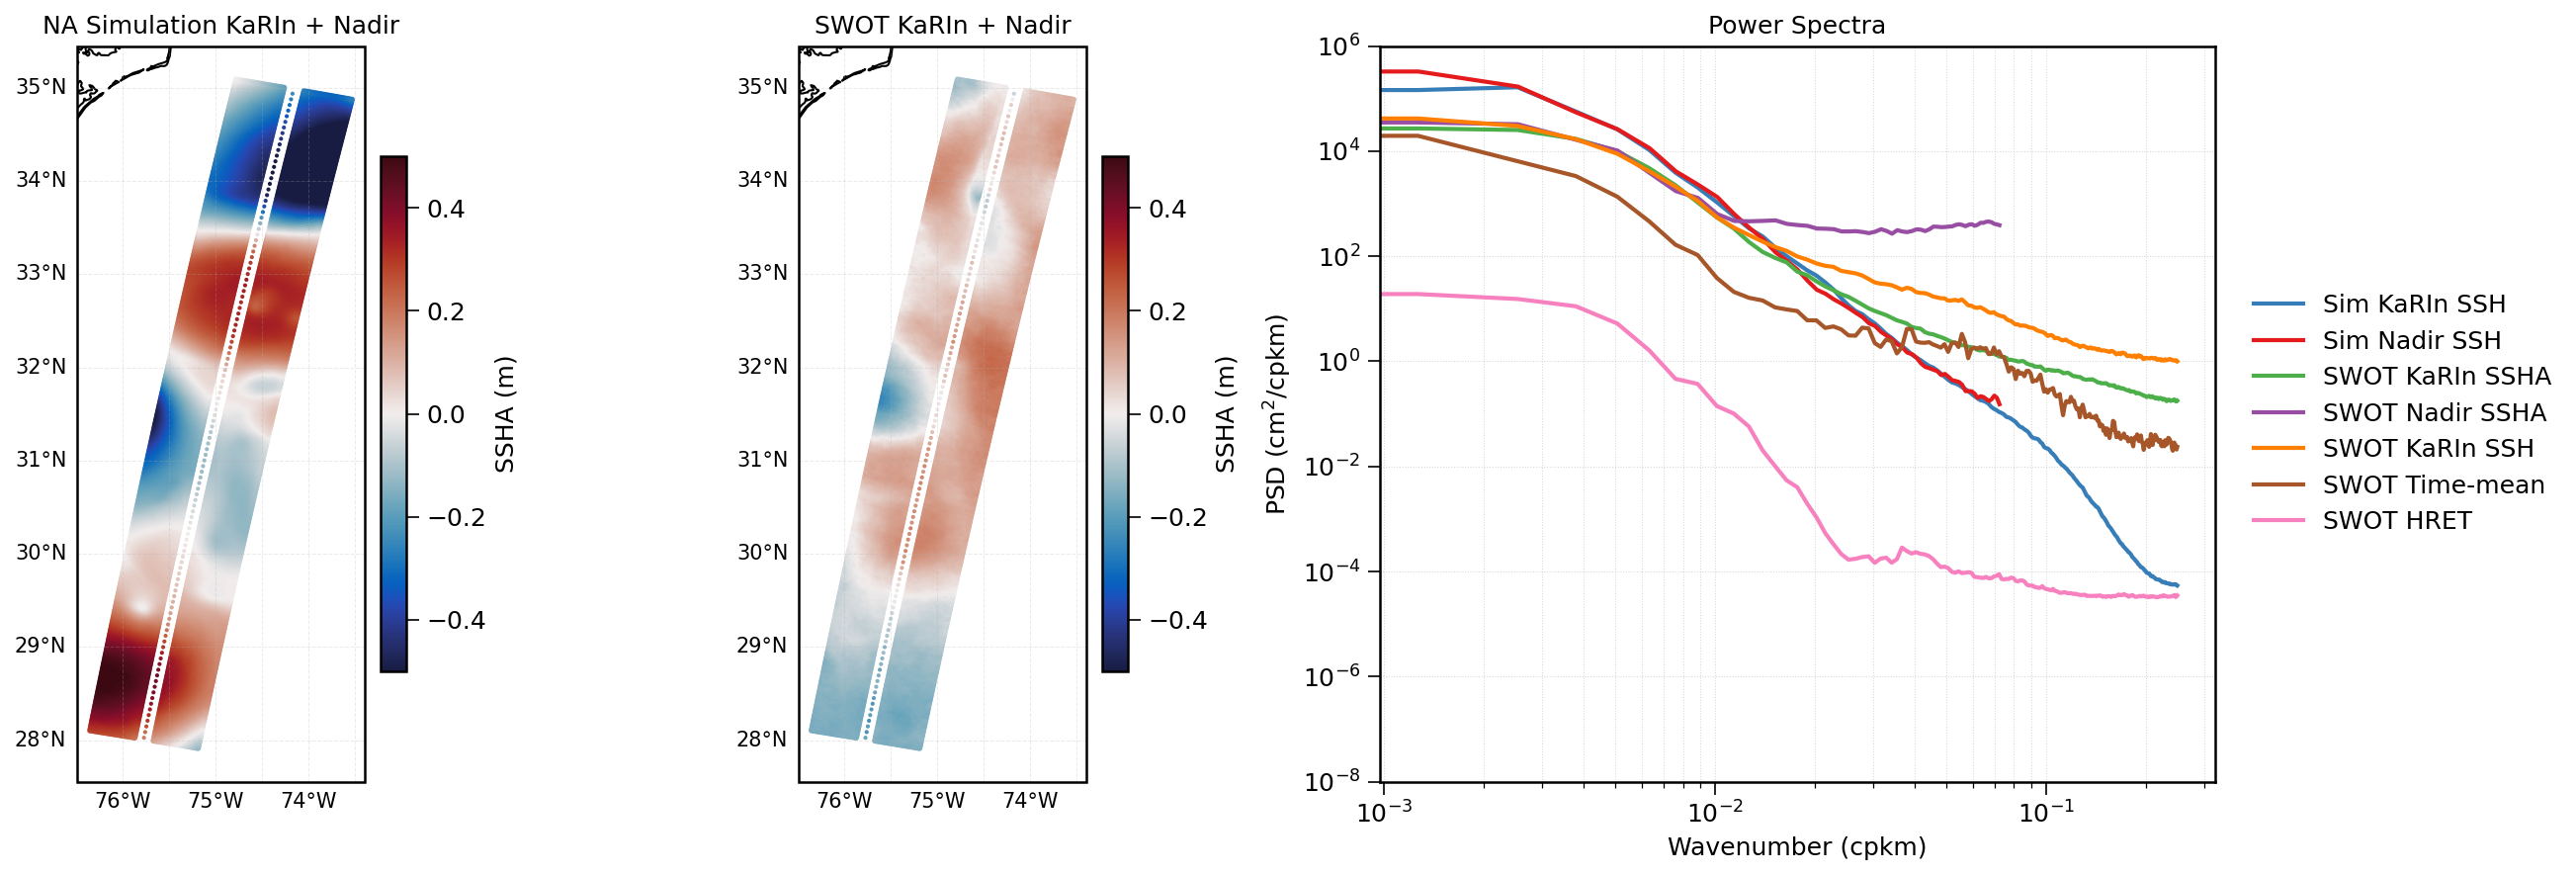

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cmocean

swot.set_plot_style()

index = 40
vmin, vmax = -0.5, 0.5
ylims = (1e-8, 1e6)
cmap = cmocean.cm.balance

fig = plt.figure(figsize=(18, 6), dpi=150)
gs = GridSpec(1, 3, width_ratios=[1, 1, 1.6], figure=fig)

# ───── Simulation Map ─────
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
sc0 = ax0.scatter(
    karin.lon[index].flatten(), karin.lat[index].flatten(),
    c=karin_NA.ssha[index].flatten(), s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o'
)
ax0.scatter(
    nadir.lon[index], nadir.lat[index], c=nadir_NA.ssha[index], vmin=vmin, vmax=vmax,
    cmap=cmap, s=1, marker='o', transform=ccrs.PlateCarree()
)
ax0.coastlines()
ax0.set_title("NA Simulation KaRIn + Nadir")
gl0 = ax0.gridlines(draw_labels=True, linewidth=0.5, alpha=0.25)
gl0.top_labels = gl0.right_labels = False
cbar0 = fig.colorbar(sc0, ax=ax0, orientation='vertical', shrink=0.7, pad=0.03)
cbar0.set_label("SSHA (m)")

# ───── SWOT Map ─────
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
sc1 = ax1.scatter(
    karin.lon[index], karin.lat[index],
    c=karin.ssha[index], s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o'
)
ax1.scatter(
    nadir.lon[index], nadir.lat[index],
    c=nadir.ssh[index], s=1, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o'
)
ax1.coastlines()
ax1.set_title(f'SWOT KaRIn + Nadir')
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.25)
gl1.top_labels = gl1.right_labels = False
cbar1 = fig.colorbar(sc1, ax=ax1, orientation='vertical', shrink=0.7, pad=0.03)
cbar1.set_label("SSHA (m)")

# ───── Power Spectrum ─────
ax2 = fig.add_subplot(gs[0, 2])
ax2.loglog(karin_NA.wavenumbers_cpkm, karin_NA.spec_alongtrack_av, label='Sim KaRIn SSH', linewidth=2)
ax2.loglog(nadir_NA.wavenumbers_cpkm, nadir_NA.spec_ssh, label='Sim Nadir SSH', linewidth=2)
#ax2.loglog(karin_NA.wavenumbers * 1e3, karin_NA.spec_ssh, label='Sim KaRIn SSH', linewidth=1.5)

ax2.loglog(karin.wavenumbers_cpkm, karin.spec_alongtrack_av, label='SWOT KaRIn SSHA', linewidth=2)
ax2.loglog(nadir.wavenumbers_cpkm, nadir.spec_alongtrack_av, label='SWOT Nadir SSHA', linewidth=2)
ax2.loglog(karin.wavenumbers_cpkm, karin.spec_ssh, label='SWOT KaRIn SSH', linewidth=2.0)
ax2.loglog(karin.wavenumbers_cpkm, karin.spec_tmean, label='SWOT Time-mean', linewidth=2.0)
#ax2.loglog(karin.wavenumbers * 1e3, karin.spec_filt_tmean, label='SWOT Filtered', linewidth=1.2)
ax2.loglog(karin.wavenumbers_cpkm, karin.spec_tide, label='SWOT HRET', linewidth=2.0)

ax2.set_xlabel("Wavenumber (cpkm)")
ax2.set_ylabel("PSD (cm$^2$/cpkm)")
ax2.set_ylim(ylims)
ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
ax2.grid(True, which='both', linestyle=':', linewidth=0.5)
ax2.set_title("Power Spectra")

print(f"Pass {pass_num:03d}  Cycle {shared_cycles[index]:03d}")
print(karin.time_dt[index])


plt.tight_layout()
plt.show()


## 3. Estimate the balanced and unbalanced components of the SWOT data


---- KaRIn spectrum parameters ----
Amp. balanced   :   2.6756e+04 ± 2.39e+02
lambda balanced :   2.2340e+02 ± 1.39e+00
slope balanced  :   4.7161e+00 ± 5.09e-02
Amp. noise      :   4.3583e+01 ± 3.48e+01
lambda noise    :   1.0001e+02 ± 4.83e+01
slope noise     :   1.7609e+00 ± 2.28e-02


---- Nadir spectrum parameters ----
Fitted Nadir noise floor N = 326.15501142043803 ± 1.46e+01



(<Figure size 960x480 with 2 Axes>,
 array([<Axes: title={'center': 'KaRIn'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>,
        <Axes: title={'center': 'Nadir'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>],
       dtype=object))

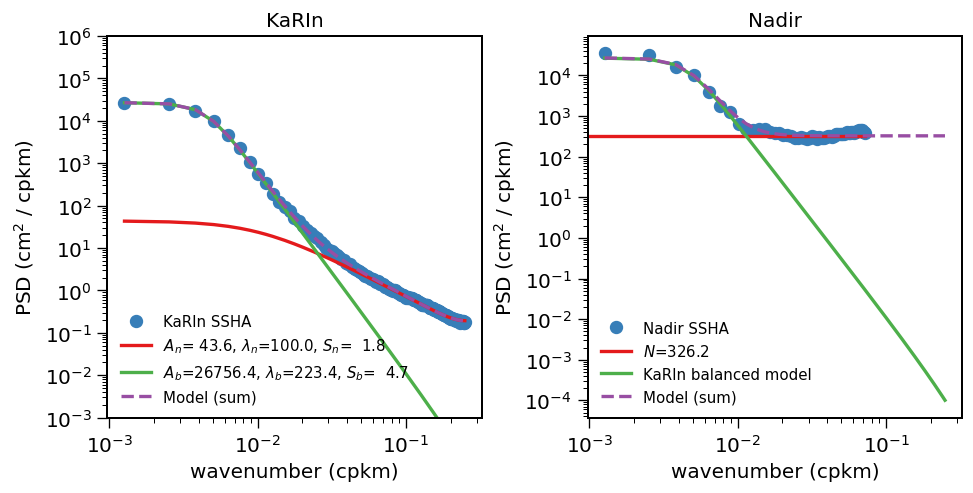

In [16]:
# KaRIn model fit
p_karin, _ = swot.fit_spectrum(karin, karin.spec_alongtrack_av, swot.karin_model)

# Nadir model fit
p_nadir, _= swot.fit_nadir_spectrum(nadir, nadir.spec_alongtrack_av, p_karin)

# Plot the fits
swot.plot_spectral_fits(karin, nadir, p_karin, p_nadir)

## 4. Generate Covariances for the SWOT data signal and noise

We now generate covariance functions for our spectrum models of the SWOT data to synthesize the noise component of the SWOT spectrum. We wont extend the target grid at the stage, we will keep it at 60. 


In [ ]:
import scipy.linalg as la

# --- Grid and Spacing ---
nx, ny = 2 * karin.swath_width, karin.track_length
nn = nadir.track_length
dx, dy, dn = karin.dx_km, karin.dy_km, nadir.dy_km

# --- Covariance Functions ---
c_bal = swot.balanced_covariance_func(p_karin)
c_unb = swot.noise_covariance_func(p_karin)

N_n = p_nadir[0]
sigma_noise = np.sqrt(N_n / (2 * dn))

# --- Observation Points ---
xk, yk = karin.x_obs_grid.flatten()*1e-3, karin.y_obs_grid.flatten()*1e-3
xn, yn = nadir.x_grid.flatten()*1e-3, nadir.y_grid.flatten()*1e-3
xobs = np.concatenate((xk, xn))
yobs = np.concatenate((yk, yn))

# --- Covariance and Noise Matrices ---
C = swot.build_covariance_matrix(c_bal, xobs, yobs)
N, Nk = swot.build_noise_matrix(c_unb, xk, yk, sigma_noise, nn, nx*ny)

# --- Cholesky Decomposition ---
F = swot.cholesky_decomp(C, "C")
Fk = swot.cholesky_decomp(Nk, "Nk")
cho_tuple = la.cho_factor(C + N, lower=True)

# --- Generate Synthetic SWOT Signal+ Noise ---
h, eta, eta_k, eta_n = swot.generate_signal_and_noise(F, Fk, sigma_noise, nx*ny, nn)

# --- Target (Reconstruction) Grid ---
xt, yt, nxt, nyt, _, _ = swot.make_target_grid(karin, unit='km', extend=False)

# --- Cross covariance between target and observation points
R = c_bal(np.hypot(xt[:, None] - xobs, yt[:, None] - yobs))

# --- Estimate Signal on Target Grid ---
ht = swot.estimate_signal_on_target_cho_solve(R, cho_tuple, h + eta) # faster function


---- Hankel Transform ----
Δk (spacing): 0.000100 cpkm
k_max (maximum wavenumber): 250.000000 cpkm
Variance from spectrum:   129.085489
Variance from covariance: 129.085489


---- Hankel Transform ----
Δk (spacing): 0.000100 cpkm
k_max (maximum wavenumber): 0.250000 cpkm
Variance from spectrum:   0.769978
Variance from covariance: 0.769978

Calculating covariance matrices...


/scratch/jskinner1/job_43876971/ipykernel_1673215/2351889332.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


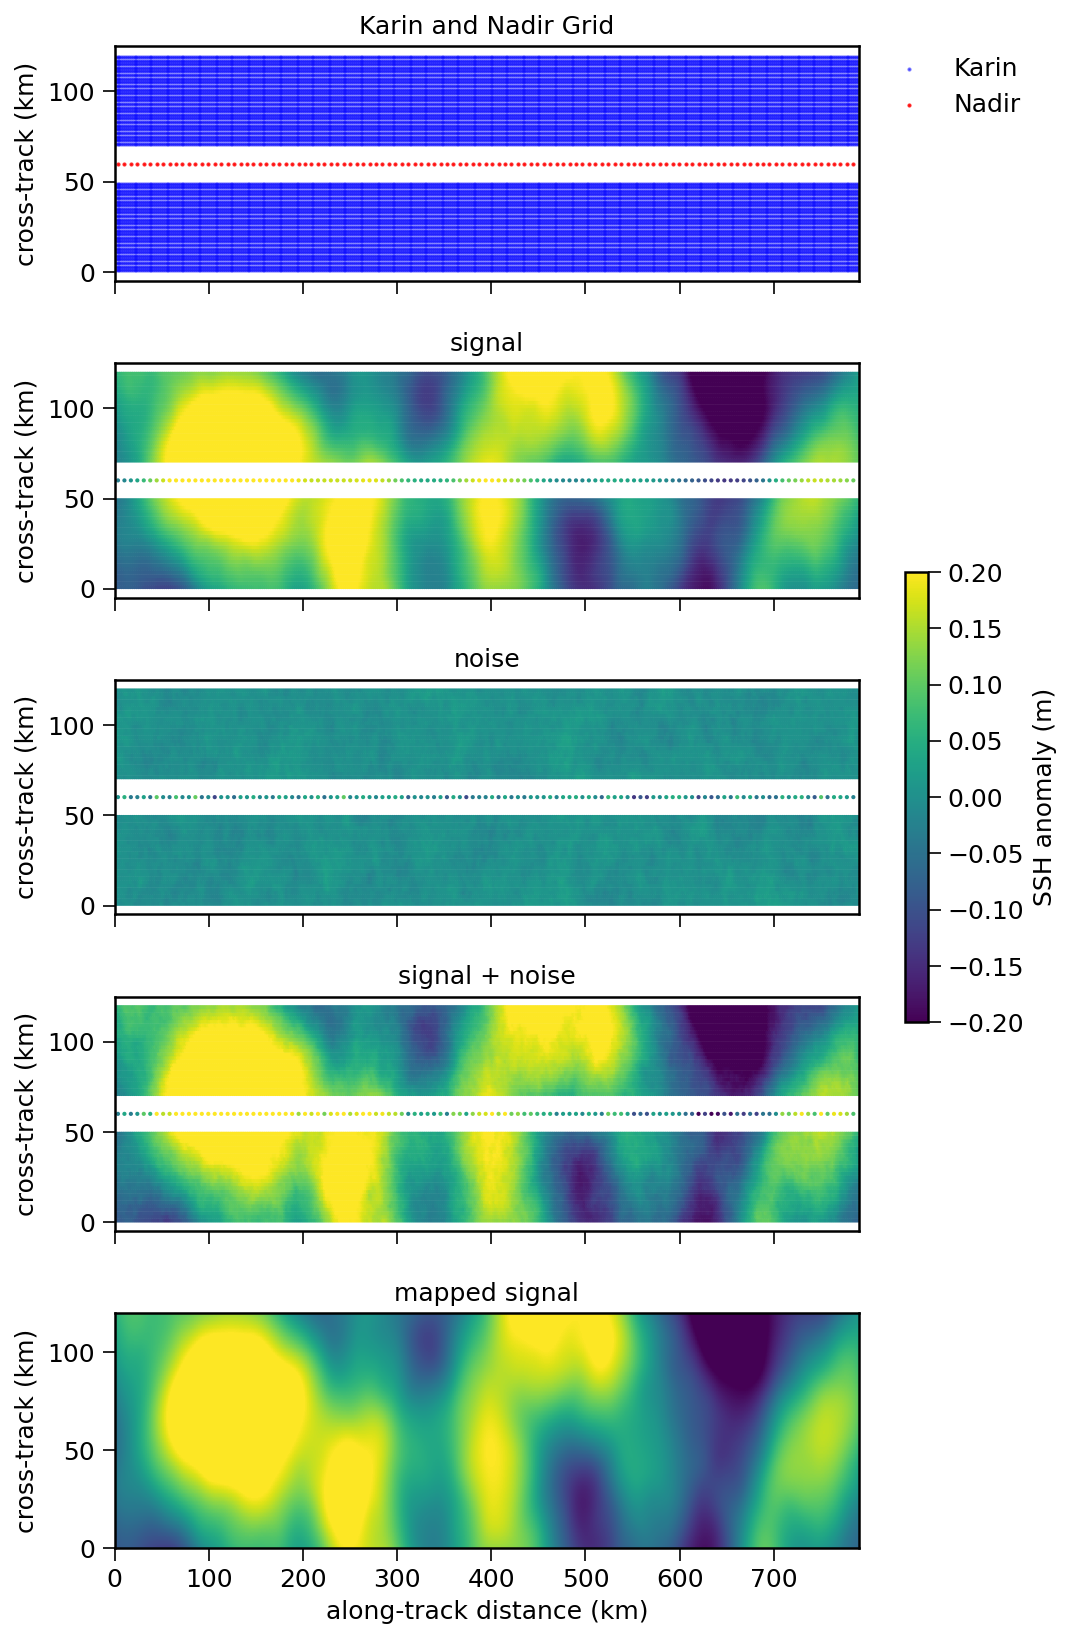

<Figure size 1050x750 with 0 Axes>

<Figure size 1050x750 with 0 Axes>

In [8]:
# Check the generation 
fig, axes = plt.subplots(
    5, 1, figsize=(8, 13), sharex=True,
    gridspec_kw={'hspace': 0.35}
)

vmin = -0.2 
vmax = 0.2

axes[0].scatter(yk, xk, s=1,  c='blue', label='Karin', alpha=0.5)
axes[0].scatter(yn, xn, s=1, c='red',  label='Nadir', alpha=0.8)
axes[0].set_title('Karin and Nadir Grid')
axes[0].set_ylabel('cross-track (km)')
axes[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

axes[1].scatter(yobs, xobs, c = h/100,  s=1, vmin=vmin, vmax=vmax)
axes[1].set_title('signal')
axes[1].set_ylabel('cross-track (km)')

axes[2].scatter(yobs, xobs, c = eta/100, s=1, vmin=vmin, vmax=vmax)
axes[2].set_title('noise')
axes[2].set_ylabel('cross-track (km)')

axes[3].scatter(yobs, xobs, c = (h + eta)/100, s=1, vmin=vmin, vmax=vmax)
axes[3].set_title('signal + noise')
axes[3].set_ylabel('cross-track (km)')

im = axes[4].imshow(
    ht.reshape((nyt, nxt)).T/100, origin='lower',
    extent=np.array([0, nyt * karin.dy, 0, nxt * karin.dx]) * 1e-3,
    vmin=vmin, vmax=vmax, aspect='auto'
)
axes[4].set_title('mapped signal')
axes[4].set_xlabel('along-track distance (km)')
axes[4].set_ylabel('cross-track (km)')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3, pad=0.05)
cbar.set_label('SSH anomaly (m)')

plt.tight_layout()
plt.show()
plt.gcf()

### Generate synthetic obervations from covariance functions and reconstruct the spectrum of original field

In [9]:
# generates n synthetic realisations of the signal and noise
n_realizations = karin_NA.ssha.shape[0]
hs, etas, etas_k, etas_n = swot.generate_synthetic_realizations(swot, F, Fk, sigma_noise, nx, ny, nn, n_realizations)

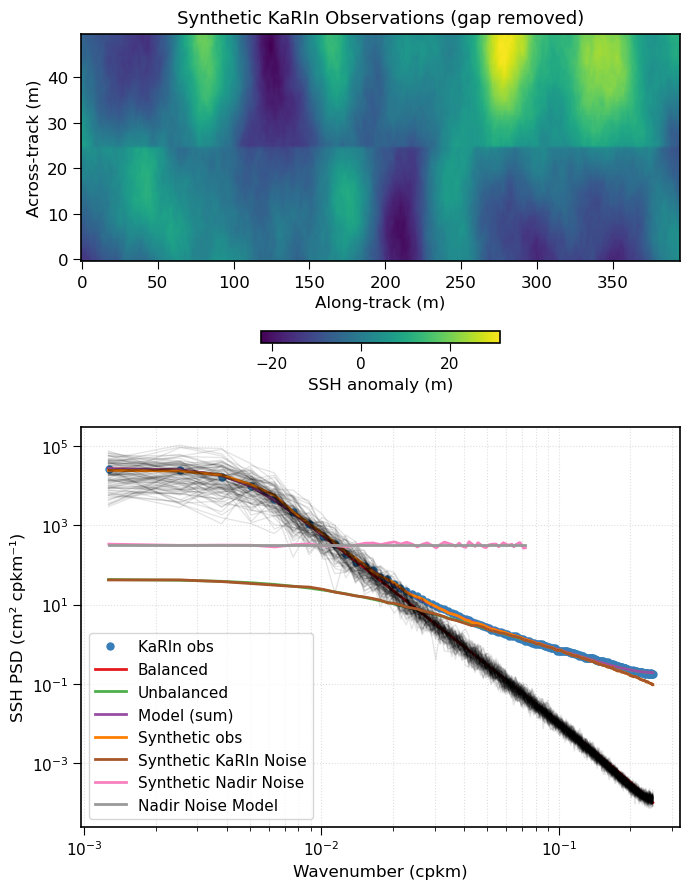

In [10]:
# Plot the mean of the synthetic realisations
import xarray as xr

# karin component
h_k = hs[:, :nx*ny]  # karin signal  
h_combined = h_k  + etas_k.reshape(etas_k.shape[0], -1) # karin signal + noise

# Get the one-sided spectra
k_karin = karin.wavenumbers_cpkm[int(karin.track_length/2):]  # units [1/m]
karin_spec_sample_mean = karin.spec_alongtrack_av[int(karin.track_length/2):]
k_nadir = nadir.wavenumbers_cpkm[int(nadir.track_length/2):]  # units [1/m]
nadir_spec_sample_mean = nadir.spec_alongtrack_av[int(nadir.track_length/2):]

# Put the wavenumbers through the models to get the functional form
spbalanced = swot.balanced_model_tapered(k_karin[1:], *poptcwg_karin[0:3])
spunbalanced = swot.unbalanced_model_tapered(k_karin, *poptcwg_karin[3:7])
spnoise_nadir = swot.nadir_noise_model(k_nadir, poptcwg_nadir[0])

# h_syn is the combined reshaped into (time, nx, ny)
h_syn = np.zeros((hs.shape[0], ny, nx))
h_bal = np.zeros((hs.shape[0], ny, nx))
for i in range(hs.shape[0]):
    h_syn[i, :, :] = h_combined[i, :].reshape(ny, nx)
    h_bal[i, :, :] = h_k[i, :].reshape(ny, nx)

# ---- Spectra ----
h_syn_coords = { 
    'sample': np.arange(h_syn.shape[0]),
    'pixel':  np.arange(h_syn.shape[2])*karin_NA.dx_km,   # along-track
    'line':  np.arange(h_syn.shape[1])*karin_NA.dy_km   # cross-track
}

h_syn_xr = xr.DataArray(h_syn, coords = h_syn_coords, dims = ['sample', 'line', 'pixel'])
spec_h_syn = swot.mean_power_spectrum(h_syn_xr, karin.window, 'line', ['sample', 'pixel'])
spec_h_syn = spec_h_syn[int(karin.track_length/2):]

eta_k_xr = xr.DataArray(etas_k, coords = h_syn_coords, dims = ['sample', 'line', 'pixel'])
eta_k_syn = swot.mean_power_spectrum(eta_k_xr, karin.window, 'line', ['sample', 'pixel'])
spec_eta_k = eta_k_syn[int(karin.track_length/2):]

h_bal_xr = xr.DataArray(h_bal, coords = h_syn_coords, dims = ['sample', 'line', 'pixel'])
h_bal_syn = swot.mean_power_spectrum(h_bal_xr, karin.window, 'line', ['pixel'])
h_bal_k = h_bal_syn[:, int(karin.track_length/2):]

# compute the nadir spectrum
eta_nt_coords = {
    'sample': np.arange(etas_n.shape[0]),
    'nadir_line': np.arange(0.5, etas_n.shape[1], 1.0) * nadir.dy_km
}

eta_n_xr = xr.DataArray(etas_n, coords = eta_nt_coords, dims = ['sample', 'nadir_line'])
spec_eta_n = swot.mean_power_spectrum(eta_n_xr, nadir.window, 'nadir_line', ['sample'])
spec_eta_n = spec_eta_n[int(nadir.track_length/2):]

# ---- PLOT ----
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 9), dpi=100, gridspec_kw={'height_ratios': [0.7, 0.8]})

sc = ax1.imshow(h_syn[0, :, :].T, aspect='auto', origin='lower')
ax1.set_title('Synthetic KaRIn Observations (gap removed)', fontsize=13, pad=8)
ax1.set_ylabel('Across‐track (m)', fontsize=12)
ax1.set_xlabel('Along‐track (m)', fontsize=12)
cbar = plt.colorbar(sc, ax=ax1, orientation='horizontal', shrink=0.4, pad=0.2)
cbar.ax.tick_params(labelsize=11)
cbar.set_label('SSH anomaly (m)', fontsize=12)

# ax2.loglog(karin_NA.wavenumbers * 1e3, karin_NA.spec_alongtrack_av, label='Sim KaRIn SSH', linewidth=2)
ax2.loglog(k_karin , karin_spec_sample_mean, 'o', markersize=5, label='KaRIn obs') # from above
ax2.loglog(k_karin[1:], spbalanced, lw=2, label='Balanced') # from above model
ax2.loglog(k_karin[1:], spunbalanced[1:], lw=2, label='Unbalanced') # from above model
ax2.loglog(k_karin[1:], (spunbalanced[1:] + spbalanced), '-', lw=2, label='Model (sum)') # from above model
ax2.loglog(k_karin[1:], spec_h_syn[1:], '-', lw=2, label='Synthetic obs')
for i in range(0, h_bal_k.shape[0]):
    ax2.loglog(k_karin[1:], h_bal_k[i, 1:], 'k-', lw=1, alpha=0.1)
ax2.loglog(k_karin[1:], spec_eta_k[1:], lw=2, label='Synthetic KaRIn Noise')
ax2.loglog(k_nadir[1:], spec_eta_n[1:], lw=2, label='Synthetic Nadir Noise')
plt.loglog(k_nadir[1:], spnoise_nadir[1:], label = r'Nadir Noise Model')

ax2.set_xlabel('Wavenumber (cpkm)', fontsize=12)
ax2.set_ylabel('SSH PSD (cm² cpkm⁻¹)', fontsize=12)
ax2.legend(loc='lower left', fontsize=11, frameon=True)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.grid(True, which='both', linestyle=':', alpha=0.4)

plt.tight_layout(h_pad=2)
plt.show()

#### Use noise models to generate synthetic SWOT observations from the NA simulation data

<xarray.DataArray (freq_nadir_line: 58)>
array([ 41693.36310691, 144857.7075382 , 122715.22442074,  47493.18828316,
        19673.20676421,  10456.44917328,   4399.98518055,   2591.56397338,
         1619.24327415,    877.28764477,    611.56495593,    563.02172061,
          473.88542115,    474.45432414,    422.31273103,    389.31296529,
          388.87700851,    353.59251876,    385.45080723,    368.42085282,
          317.58279273,    343.17029742,    362.5103457 ,    323.77424312,
          278.30703808,    336.38390206,    384.30395683,    351.92914275,
          326.76456595,    295.92552232,    357.83747926,    296.70187484,
          282.40780119,    390.85266147,    342.98735242,    294.14666824,
          362.14340381,    322.17773901,    286.48259383,    276.2158015 ,
          323.41289774,    331.6900901 ,    338.19255777,    335.51492439,
          289.29798053,    321.60882828,    362.57215949,    341.80707043,
          320.58081956,    320.4519812 ,    336.10159027,  

/scratch/jskinner1/job_43876971/ipykernel_1673215/3405826039.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


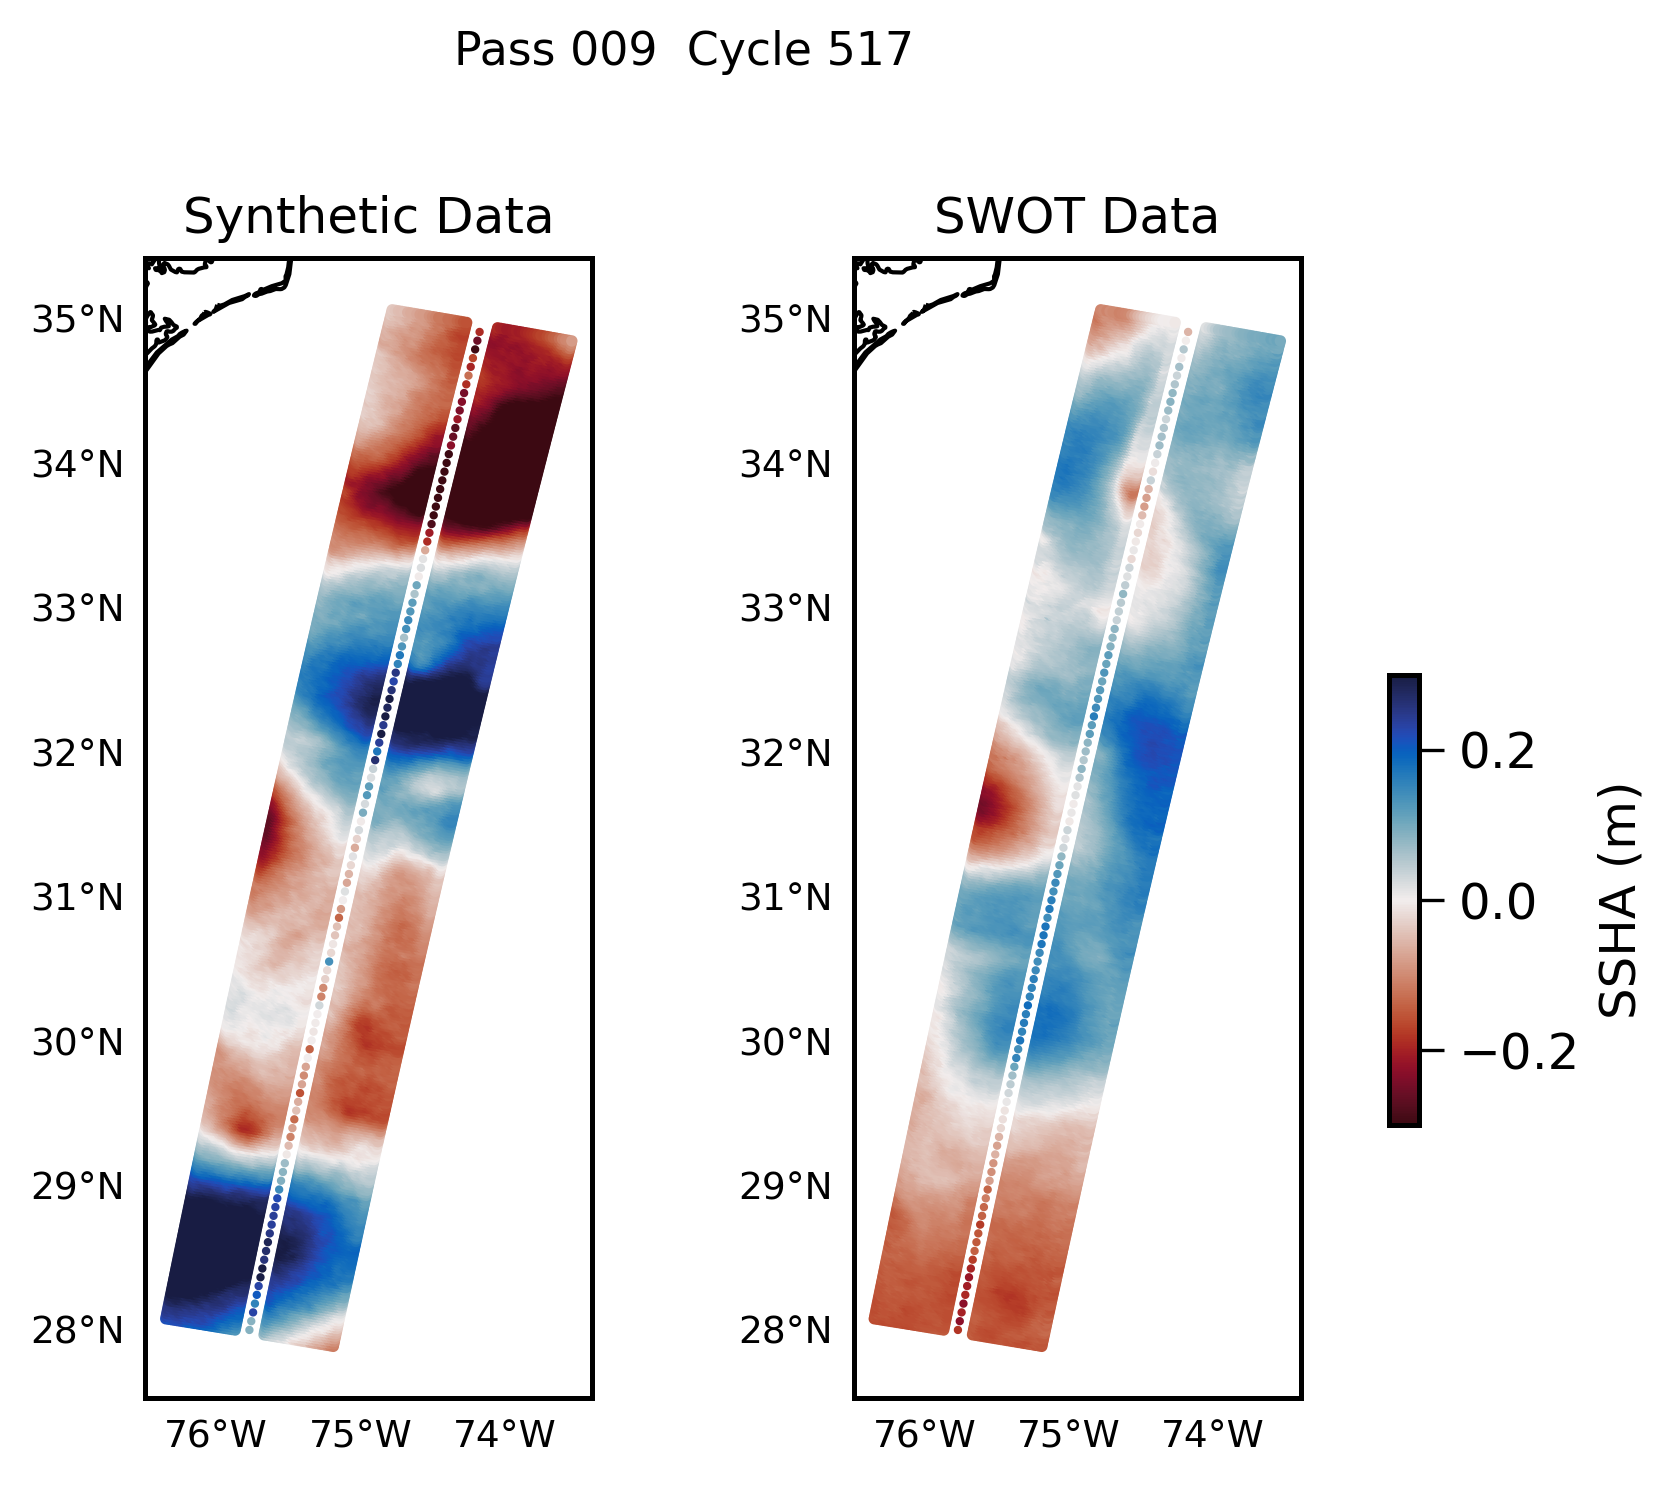

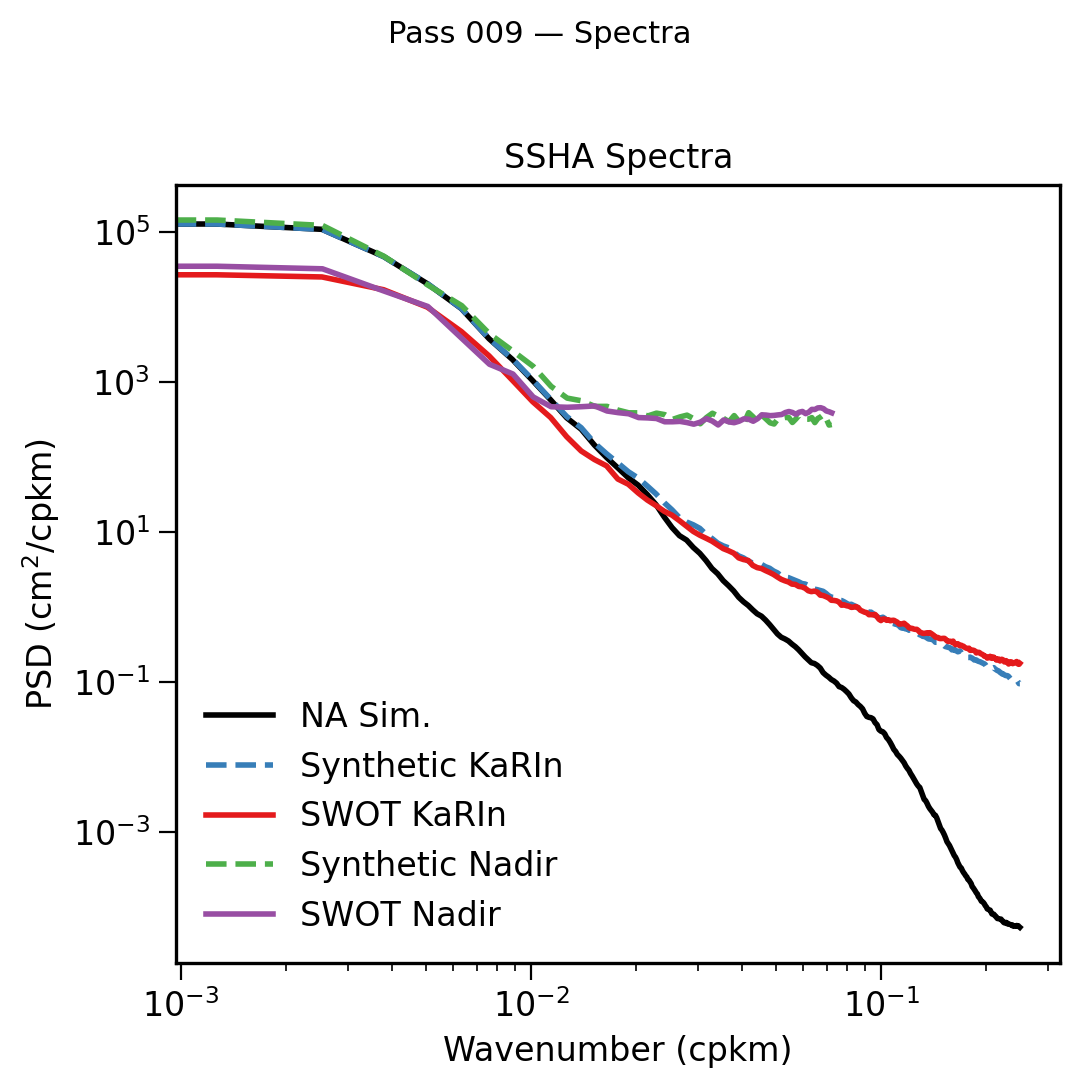

In [11]:
# Now we generate our Karin and Nadir noise based on synthetic realizations of the SWOT models 
index = 40 # time index we want to estimate on

ntime = karin_NA.ssha.shape[0] # simulation times
vmin = -0.3
vmax = 0.3 

cmap = 'cmo.balance_r'

ssh_noisy = np.empty_like(karin_NA.ssha) # new arrays for synthetic SWOT NA data
ssh_nadir_noisy = np.empty_like(nadir_NA.ssha)

for t in range(0, ntime):

    ssh = karin_NA.ssha[t, :, :] 
    mask = np.isfinite(ssh)      # mask the gap out

    eta_k_reshaped = np.full_like(ssh, np.nan)  
    eta_k_current = etas_k[t, :, :] 

    # Direct assignment of flattened valid data:
    eta_k_reshaped[mask] = eta_k_current.flatten()

    # Add noise to SSH, preserving gaps:
    ssh_noisy[t, :, :] = ssh + 1e-2 * eta_k_reshaped

    # --- Nadir ---
    ssh_nadir = nadir_NA.ssha[t, :]
    ssh_nadir_noisy[t] = ssh_nadir + 1e-2 * etas_n[t]


kt_NA_coords    = [np.arange(ntime), karin.y_coord_km, karin.x_coord_km]
ssh_noisy_xr = xr.DataArray(ssh_noisy * 100, coords = kt_NA_coords, dims = ['sample', 'line', 'pixel'])
spec_ssh_noisy = swot.mean_power_spectrum(ssh_noisy_xr, karin.window, 'line', ['sample', 'pixel'])
spec_ssh_noisy = spec_ssh_noisy[int(karin.track_length/2):] # take the half spectrum

nad_noisy_xr   = xr.DataArray(ssh_nadir_noisy * 100, coords = eta_nt_coords, dims = ['sample', 'nadir_line'])
spec_nad_noisy = swot.mean_power_spectrum(nad_noisy_xr, nadir.window, 'nadir_line', ['sample'])
spec_nad_noisy = spec_nad_noisy[int(nadir.track_length/2):]
print(spec_nad_noisy)

karin_NA.ssh_noisy = ssh_noisy # save the generated noisy fields to our NA simulation classes 
nadir_NA.ssh_noisy = ssh_nadir_noisy

# Save noisy fields back to simulation objects (as before)
karin_NA.ssh_noisy = ssh_noisy
nadir_NA.ssh_noisy = ssh_nadir_noisy

print(karin.time_dt[index])
print(shared_cycles[index])

# --------------------
# Figure 1: Fields (two maps)
# --------------------
fig1 = plt.figure(figsize=(5, 5), dpi=300)
# left: synthetic noisy fields (KaRIn + nadir)
ax0 = fig1.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
sc0 = ax0.scatter(
    karin.lon[index].flatten(), karin.lat[index].flatten(),
    c=(ssh_noisy[index] - np.nanmean(ssh_noisy[index])).flatten(), s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o', rasterized=True
)
# overlay nadir noisy points
ax0.scatter(
    nadir.lon[index], nadir.lat[index], c=(ssh_nadir_noisy[index] - np.nanmean(ssh_nadir_noisy[index])), vmin=vmin, vmax=vmax,
    cmap=cmap, s=1, marker='o', transform=ccrs.PlateCarree(), rasterized=True
)
ax0.coastlines()
ax0.set_title("Synthetic Data")
gl0 = ax0.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl0.top_labels = gl0.right_labels = False
gl0.xlabel_style = {'size': 9}
gl0.ylabel_style = {'size': 9}

# right: original SWOT fields (KaRIn + nadir)
ax1 = fig1.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
sc1 = ax1.scatter(
    karin.lon[index].flatten(), karin.lat[index].flatten(),
    c=karin.ssha[index].flatten(), s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o', rasterized=True
)
ax1.scatter(
    nadir.lon[index], nadir.lat[index], c=nadir.ssh[index], s=1, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o', rasterized=True
)
ax1.coastlines()
ax1.set_title("SWOT Data")
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl1.top_labels = gl1.right_labels = False
gl1.xlabel_style = {'size': 9}
gl1.ylabel_style = {'size': 9}

cbar_ax = fig1.add_axes([0.97, 0.25, 0.02, 0.3])  # [left, bottom, width, height] in figure coords
cbar = fig1.colorbar(sc1, cax=cbar_ax, orientation='vertical', shrink = 0.3)
cbar.set_label("SSHA (m)")

plt.suptitle(f"Pass {pass_num:03d}  Cycle {shared_cycles[index]:03d}", fontsize=11)
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig1.savefig('synthetic_swot_fields.pdf', bbox_inches='tight')
# fig1.show() or plt.show() below after second figure

# --------------------
# Figure 2: Spectra (own figure)
# --------------------
fig2 = plt.figure(figsize=(5.5, 5.5), dpi=200)
ax2 = fig2.add_subplot(1, 1, 1)

ax2.loglog(karin_NA.wavenumbers_cpkm, karin_NA.spec_alongtrack_av, 'k', label='NA Sim.', linewidth=2.0)
ax2.loglog(spec_ssh_noisy.freq_line, spec_ssh_noisy, '--',label='Synthetic KaRIn', linewidth=2.0)
ax2.loglog(karin.wavenumbers_cpkm, karin.spec_alongtrack_av, '-', label='SWOT KaRIn', linewidth=2.0)
ax2.loglog(k_nadir, spec_nad_noisy, '--', label='Synthetic Nadir', linewidth=2.0)
ax2.loglog(nadir.wavenumbers_cpkm, nadir.spec_alongtrack_av, '-', label='SWOT Nadir', linewidth=2.0)
# ax2.loglog(k_karin, 100*spec_eta_k, '--', lw=1.0, color='k')#, label='KaRIn Noise Model')
# ax2.loglog(k_nadir, 100*spec_eta_n, '--', lw=1.0, color='k')#, label='Nadir Noise Model')

ax2.set_xlabel("Wavenumber (cpkm)")
ax2.set_ylabel("PSD (cm$^2$/cpkm)")
ax2.set_title("SSHA Spectra")
#ax2.set_ylim(1e-3, 1e7)
ax2.legend(loc='best')
#ax2.grid(True, which='both', linestyle='--', linewidth=0.4)

plt.suptitle(f"Pass {pass_num:03d} — Spectra", fontsize=11)
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig2.savefig('synthetic_swot_spectra.pdf', bbox_inches='tight')

# show both
plt.show()

/scratch/jskinner1/job_43876971/ipykernel_1673215/4132058633.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


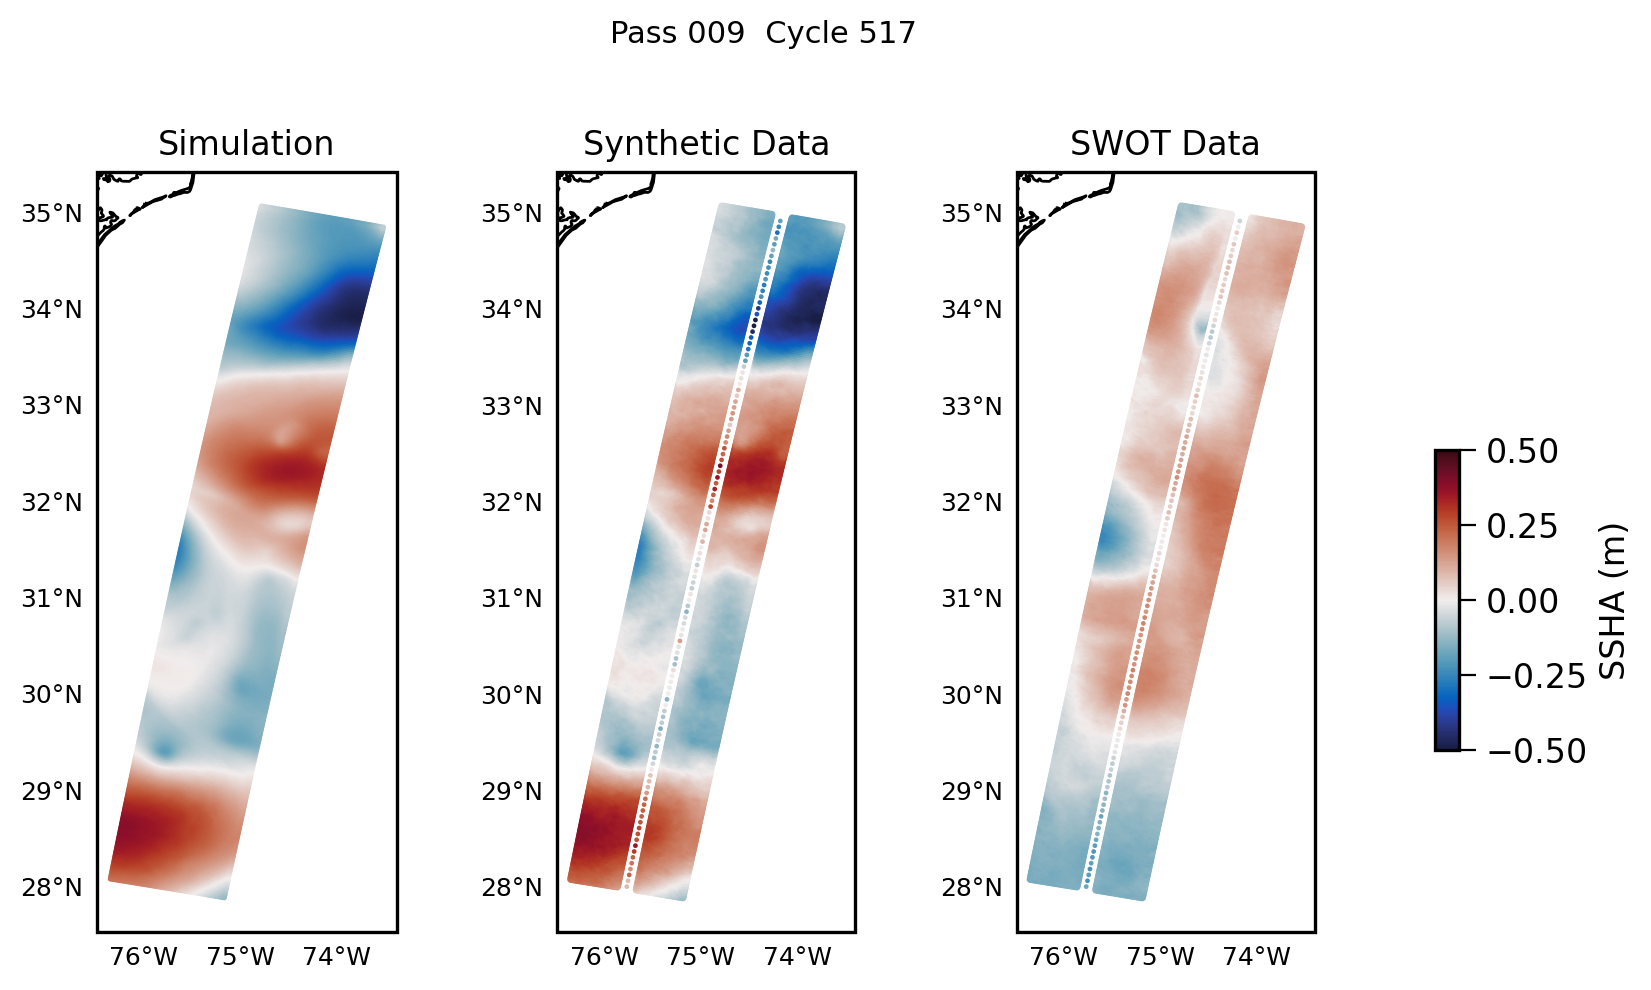

In [14]:
# --------------------
# Figure 1: Fields (three maps)
# --------------------

vmin = -0.5 
vmax = 0.5 

cmap = 'cmo.balance'
fig1 = plt.figure(figsize=(8, 5), dpi=200)

# left: model simulation (truth)
ax0 = fig1.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
sc0 = ax0.scatter(
    karin.lon_full[:, 5:65], karin.lat_full[:, 5:65], c= karin_NA.ssha_full[index][:, 5:65],
    s=1, marker='o',
    vmin=vmin, vmax=vmax, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True
)
ax0.coastlines()
ax0.set_title("Simulation")
gl0 = ax0.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl0.top_labels = gl0.right_labels = False
gl0.xlabel_style = {'size': 9}
gl0.ylabel_style = {'size': 9}

# middle: synthetic noisy fields (KaRIn + nadir)
ax1 = fig1.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
sc1 = ax1.scatter(
    karin.lon[index].flatten(), karin.lat[index].flatten(),
    c=(ssh_noisy[index] - np.nanmean(ssh_noisy[index])).flatten(),
    s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o', rasterized=True
)
ax1.scatter(
    nadir.lon[index], nadir.lat[index],
    c=(ssh_nadir_noisy[index] - np.nanmean(ssh_nadir_noisy[index])),
    vmin=vmin, vmax=vmax, cmap=cmap,
    s=0.5, marker='o', transform=ccrs.PlateCarree(), rasterized=True
)
ax1.coastlines()
ax1.set_title("Synthetic Data")
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl1.top_labels = gl1.right_labels = False
gl1.xlabel_style = {'size': 9}
gl1.ylabel_style = {'size': 9}

# right: original SWOT fields (KaRIn + nadir)
ax2 = fig1.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
sc2 = ax2.scatter(
    karin.lon[index].flatten(), karin.lat[index].flatten(),
    c=karin.ssha[index].flatten(),
    s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o', rasterized=True
)
ax2.scatter(
    nadir.lon[index], nadir.lat[index],
    c=nadir.ssh[index], s=0.5, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o', rasterized=True
)
ax2.coastlines()
ax2.set_title("SWOT Data")
gl2 = ax2.gridlines(draw_labels=True, linewidth=0.5, alpha=0.0)
gl2.top_labels = gl2.right_labels = False
gl2.xlabel_style = {'size': 9}
gl2.ylabel_style = {'size': 9}

# Shared colorbar
cbar_ax = fig1.add_axes([0.92, 0.25, 0.015, 0.3])
cbar = fig1.colorbar(sc2, cax=cbar_ax, orientation='vertical')
cbar.set_label("SSHA (m)")

plt.suptitle(f"Pass {pass_num:03d}  Cycle {shared_cycles[index]:03d}", fontsize=11)
plt.tight_layout(rect=[0, 0, 0.9, 0.96])
fig1.savefig('synthetic_swot_fields.pdf', bbox_inches='tight')


In [19]:
# test: apply the balanced model fit the NA sim karin
k_karin_NA = (karin_NA.wavenumbers_cpkm[int(karin_NA.track_length/2):]) # this is in units [1/m] 
karin_spec_sample_mean_NA = karin_NA.spec_alongtrack_av[int(karin_NA.track_length/2):]

spec_ssh_noisy = swot.mean_power_spectrum(ssh_noisy_xr, karin.window, 'line', ['sample', 'pixel'])
spec_ssh_noisy_half = spec_ssh_noisy[int(karin.track_length/2):] # take the half spectrum

# KARIN
poptcwg_karin_NA, pcovcwg_karin_NA = swot.fit_spectrum(karin_NA, spec_ssh_noisy, swot.karin_model)

# plot KARIN
spbalanced = swot.balanced_model(k_karin_NA[1:],*poptcwg_karin_NA[0:3])
spunbalanced = swot.unbalanced_model(k_karin_NA,*poptcwg_karin_NA[3:7])

plt.figure(figsize=(5.5,5), dpi=120)
k_km = k_karin # wavenumbers in km for plotting
plt.loglog(k_km[1:], karin_spec_sample_mean_NA[1:],'o', label = 'Simulation Data')
plt.loglog(k_km[1:], spunbalanced[1:],label = r'Unbalanced: $A_n$=%5.3f, $\lambda_n$=%5.3f, $S_n$=%5.3f' % (poptcwg_karin_NA[3], 100, poptcwg_karin_NA[5]))
plt.loglog(k_km[1:], spbalanced,label = r'Balanced: $A_b$=%5.3f, $\lambda_b$=%5.3f, $S_b$=%5.3f' % (poptcwg_karin_NA[0], poptcwg_karin_NA[1]*1e-3, poptcwg_karin_NA[2]))
# plt.loglog(k_km[1:], (spunbalanced[1:]+spbalanced),'--',label = 'Model (sum)')
plt.loglog(k_km[1:], spec_ssh_noisy_half[1:],'-',label = 'NA Sim + SWOT Noise')
plt.xlabel('wavenumber (cpkm)')
plt.ylabel('SSH power spectral density (m$^2$ cpkm$^{-1}$)')
plt.legend(loc = 'lower left', bbox_to_anchor=(1.05, 0.5))
plt.xlim(1e-3, 3e-1)
plt.title(f'Synthetic Karin Data Pass {pass_num:03d}')


---- KaRIn spectrum parameters ----
Amp. balanced   :   1.2673e+05 ± 1.74e+03
lambda balanced :   2.7718e+02 ± 2.49e+00
slope balanced  :   4.7266e+00 ± 5.77e-02
Amp. noise      :   5.9857e+01 ± 8.07e+01
lambda noise    :   1.0000e+02 ± 7.33e+01
slope noise     :   1.9434e+00 ± 3.46e-02


AttributeError: module 'JWS_SWOT_toolbox' has no attribute 'unbalanced_model'

In [20]:
### Save the pickle files so we can read in later
karin_NA.poptcwg_karin = poptcwg_karin_NA
karin.poptcwg_karin = poptcwg_karin

with open("./pickles/karin_NA_tmean.pkl", "wb") as f:
    pickle.dump(karin_NA, f)

with open("./pickles/nadir_NA_tmean.pkl", "wb") as f:
    pickle.dump(nadir_NA, f)

with open("./pickles/nadir.pkl", "wb") as f:
    pickle.dump(nadir, f)

with open("./pickles/karin.pkl", "wb") as f:
    pickle.dump(karin, f)

## 4. Apply extraction to the NA simulation data with synthetic SWOT noise

In [13]:
from scipy.linalg import block_diag

index = 40 # time index to estimate on 

# Create covariance functions
c = swot.balanced_covariance_func(poptcwg_karin_NA)
nk = swot.noise_covariance_func(poptcwg_karin_NA)

N_n = poptcwg_nadir[0] # Nadir noise
sigma_n = np.sqrt(N_n / (2 * dn))

# Build masks
mask_k = ~np.isnan(karin_NA.ssh_noisy[index])
mask_n = ~np.isnan(nadir_NA.ssh_noisy[index])

# Obs values from our measurement 
h_obs = np.concatenate((
    karin_NA.ssh_noisy[index][mask_k].flatten(order="C"),
    nadir_NA.ssh_noisy[index][mask_n]
))

# Build covariance matrix grids in [km]
xkk = karin_NA.x_grid[mask_k].flatten(order="C")*1e-3
ykk = karin_NA.y_grid[mask_k].flatten(order="C")*1e-3
xnn = nadir_NA.x_grid.ravel()[mask_n]*1e-3
ynn = nadir_NA.y_grid.ravel()[mask_n]*1e-3

xobs = np.concatenate((xkk, xnn))
yobs = np.concatenate((ykk, ynn))

# Build covariance matrix from covariance functions
C_obs = swot.build_covariance_matrix(c, xobs, yobs)

# Build noise matrices
Nk_obs = nk(np.hypot(
    xobs[:len(xkk), None] - xobs[:len(xkk)],
    yobs[:len(xkk), None] - yobs[:len(xkk)]
))

Nn_obs = sigma_n**2 * np.eye(len(xnn))
N_obs = block_diag(Nk_obs, Nn_obs)

#build cholesky factor
cho_tuple = la.cho_factor(C_obs + N_obs, lower=True)

# target grids 
xt, yt, nxt, nyt, _, _ = swot.make_target_grid(karin_NA, unit = 'km', extend = False) # we've flipped xt and yt so the grid align

# compute the covariance first 
R = c(np.hypot(xt[:, None] - xobs, yt[:, None] - yobs))

# Estimate signal
ht_NA_sim = swot.estimate_signal_on_target_cho_solve(R, cho_tuple, h_obs) # faster function

NameError: name 'poptcwg_karin_NA' is not defined

In [ ]:
# Posterior covariance 
import numpy as np
from scipy.linalg import solve

C_target = swot.build_covariance_matrix(c, xt, yt) # Covariance of my target matrix

#  P = C_target - R(C_obs + N_obs)⁻¹ @ R.T
print("Solving linear part")
term = solve(C_obs + N_obs, R.T, assume_a='pos') # assume positive definite 

# 2. Posterior
print("posterior covariance matrix")
P = C_target - R @ term

# 3. Diagonal is posterior variance
posterior_variance = np.diag(P)

# 4. Reshape to target grid
posterior_variance_field = posterior_variance.reshape(nyt, nxt)
print("Done.")

In [ ]:
# Plot Spectrum of the Extraction we will also now overlay the Eulerian filtered field spectra

ht_NA_2d = ht_NA_sim.reshape(nyt, nxt).T

ht_NA_coords = { 
    'pixel': np.arange(0.5, np.shape(ht_NA_2d)[0], 1.0) * karin.dy_km, 
    'line': np.arange(0.5, np.shape(ht_NA_2d)[1], 1.0) * karin.dx_km
    }

ht_map_xr = xr.DataArray(ht_NA_2d * 100, coords = ht_NA_coords, dims = ['pixel', 'line'])
window_line = xr.DataArray(swot.sin2_window_func(np.shape(ht_NA_2d)[1]), dims=['line'], coords={'line': ht_map_xr['line']})
spec_ht_map = swot.mean_power_spectrum(ht_map_xr, window_line, 'line', ['pixel'])
bal_k = spec_ht_map.freq_line[int(karin.track_length/2):] 
spec_ht_map = 2 *spec_ht_map[int(karin.track_length/2):]

k_karin_NA = (karin_NA.wavenumbers_cpkm[int(karin_NA.track_length/2):]) # this is in units [1/m] 
karin_spec_sample_mean_NA = karin_NA.spec_alongtrack_av[int(karin_NA.track_length/2):]

spec_ssh_noisy = swot.mean_power_spectrum(ssh_noisy_xr, karin.window, 'line', ['sample', 'pixel'])
spec_ssh_noisy_half = spec_ssh_noisy[int(karin.track_length/2):] # take the half spectrum

plt.figure(figsize=(5.5,5), dpi=250)
k_km = k_karin # wavenumbers in km for plotting
plt.loglog(k_km[1:], karin_spec_sample_mean_NA[1:],'k-', label = 'NA Sim')
plt.loglog(k_km[1:], spec_ssh_noisy_half[1:],'-',label = 'NA Sim + KaRIn Noise')
plt.loglog(bal_k[1:], spec_ht_map[1:],color='tab:green',label = 'Balanced Extraction')
plt.loglog(bal_k[1:], all_spectra[0, 1:],color='tab:green', alpha = 1.0, label = 'Balanced Extraction')
for i in range(0, num_samples):
    plt.loglog(bal_k[1:], all_spectra[i, 1:],color='tab:green', alpha = 0.2)
plt.xlabel('Wavenumber (cpkm)')
plt.ylabel('PSD (cm$^2$/cpkm)')
plt.legend(loc = 'lower left')
#plt.xlim(1e-3, 3e-1)
plt.savefig('synth_extraction_spec.pdf', bbox_inches='tight')
#plt.title(f'Synthetic Karin Data Pass {pass_num:03d}')

In [ ]:
# Compute mean and standard deviation across realizations
spec_mean = np.mean(all_spectra, axis=0)
spec_std = np.std(all_spectra, axis=0)

# Plot mean + uncertainty
plt.figure(figsize=(5.5,5), dpi=250)

k_km = k_karin  # wavenumbers in km for plotting

# Baseline spectra
plt.loglog(k_km[1:], karin_spec_sample_mean_NA[1:], 'k-', label='NA Sim')
plt.loglog(k_km[1:], spec_ssh_noisy_half[1:], '-', label='NA Sim + KaRIn Noise')
#plt.loglog(bal_k[1:], spec_ht_map[1:], color='tab:green', label='Balanced Extraction')

# Individual realizations (transparent)
# for i in range(num_samples):
#     plt.loglog(bal_k[1:], all_spectra[i, 1:], color='blue', alpha=0.2)

# Mean + shaded error region
plt.errorbar(
    bal_k[1:], spec_mean[1:], yerr=spec_std[1:], 
    fmt='-', color='tab:green', ecolor='tab:green', elinewidth=1, capsize=2, label='Posterior Mean ±1σ'
)

# Labels and legend
plt.xlabel('Wavenumber (cpkm)')
plt.ylabel('PSD (cm$^2$/cpkm)')
plt.legend(loc='lower left')
plt.savefig('synth_extraction_spec_EB.pdf', bbox_inches='tight')


### Compute the posterior covariances for doing the error checking

In [ ]:
from scipy.linalg import solve, cholesky
import scipy.sparse as sp

def laplacian_operator(ny, nx, dx, dy):
    """
    Computes a 2D Laplacian using second-order accurate schemes.
    - Central difference for the interior.
    - Second-order one-sided (forward/backward) differences for the boundaries.
    """
    N = ny * nx
    L = sp.lil_matrix((N, N))

    def idx(i, j):
        return j * nx + i

    # Coefficients for brevity
    cx = 1 / dx**2
    cy = 1 / dy**2

    for j in range(ny):
        for i in range(nx):
            k = idx(i, j)

            # X-contribution to the Laplacian
            if i == 0:
                # 2nd-order forward difference for 2nd derivative
                L[k, idx(i, j)]     +=  2 * cx
                L[k, idx(i + 1, j)] += -5 * cx
                L[k, idx(i + 2, j)] +=  4 * cx
                L[k, idx(i + 3, j)] += -1 * cx
            elif i == nx - 1:
                # 2nd-order backward difference for 2nd derivative
                L[k, idx(i, j)]     +=  2 * cx
                L[k, idx(i - 1, j)] += -5 * cx
                L[k, idx(i - 2, j)] +=  4 * cx
                L[k, idx(i - 3, j)] += -1 * cx
            else:
                # 2nd-order central difference for 2nd derivative
                L[k, idx(i - 1, j)] +=  1 * cx
                L[k, idx(i, j)]     += -2 * cx
                L[k, idx(i + 1, j)] +=  1 * cx

            # Y-contribution to the Laplacian
            if j == 0:
                # 2nd-order forward difference
                L[k, idx(i, j)]     +=  2 * cy
                L[k, idx(i, j + 1)] += -5 * cy
                L[k, idx(i, j + 2)] +=  4 * cy
                L[k, idx(i, j + 3)] += -1 * cy
            elif j == ny - 1:
                # 2nd-order backward difference
                L[k, idx(i, j)]     +=  2 * cy
                L[k, idx(i, j - 1)] += -5 * cy
                L[k, idx(i, j - 2)] +=  4 * cy
                L[k, idx(i, j - 3)] += -1 * cy
            else:
                # 2nd-order central difference
                L[k, idx(i, j - 1)] +=  1 * cy
                L[k, idx(i, j)]     += -2 * cy
                L[k, idx(i, j + 1)] +=  1 * cy

    return L.tocsr()
    
def gradient_operator(ny, nx, dx, dy):
    """
    Computes gradient operators Gx and Gy using second-order accurate schemes.
    - Central difference for the interior.
    - Second-order one-sided (forward/backward) differences for the boundaries.
    """
    N = ny * nx
    Gx = sp.lil_matrix((N, N))
    Gy = sp.lil_matrix((N, N))

    def idx(i, j):
        return j * nx + i

    for j in range(ny):
        for i in range(nx):
            k = idx(i, j)

            # Gx operator (derivative with respect to x)
            if i == 0:
                # 2nd-order forward difference at the left edge
                Gx[k, idx(i, j)]     = -1.5 / dx
                Gx[k, idx(i + 1, j)] =  2.0 / dx
                Gx[k, idx(i + 2, j)] = -0.5 / dx
            elif i == nx - 1:
                # 2nd-order backward difference at the right edge
                Gx[k, idx(i, j)]     =  1.5 / dx
                Gx[k, idx(i - 1, j)] = -2.0 / dx
                Gx[k, idx(i - 2, j)] =  0.5 / dx
            else:
                # 2nd-order central difference for the interior
                Gx[k, idx(i - 1, j)] = -0.5 / dx
                Gx[k, idx(i + 1, j)] =  0.5 / dx

            # Gy operator (derivative with respect to y)
            if j == 0:
                # 2nd-order forward difference at the bottom edge
                Gy[k, idx(i, j)]     = -1.5 / dy
                Gy[k, idx(i, j + 1)] =  2.0 / dy
                Gy[k, idx(i, j + 2)] = -0.5 / dy
            elif j == ny - 1:
                # 2nd-order backward difference at the top edge
                Gy[k, idx(i, j)]     =  1.5 / dy
                Gy[k, idx(i, j - 1)] = -2.0 / dy
                Gy[k, idx(i, j - 2)] =  0.5 / dy
            else:
                # 2nd-order central difference for the interior
                Gy[k, idx(i, j - 1)] = -0.5 / dy
                Gy[k, idx(i, j + 1)] =  0.5 / dy

    return Gx.tocsr(), Gy.tocsr()

# Physical constants
g = 9.81
omega = 7.2921e-5
eps_f = 1e-12

# Coriolis parameter
# mean latitude scalar (simple)
mean_lat_deg = float(np.nanmean(karin.lat[index,:,:]))
lat_rad = np.deg2rad(mean_lat_deg)
f = 2.0 * omega * np.sin(lat_rad)
if abs(f) < eps_f:
    f = np.sign(f) * eps_f if f != 0 else eps_f

# Build linear operators
Gx, Gy = gradient_operator(nyt, nxt, dx=karin.dx_km, dy=karin.dy_km)
Lap = laplacian_operator(nyt, nxt, dx=karin.dx_km, dy=karin.dy_km)

# Cholesky decomposition of posterior covariance matrix: P = Lp @ Lp.T
Lp = cholesky(P, lower=True)
print("Cholesky done.")

# Scale factors for physical units
scale_grad = 1e-3   # km to m conversion
scale_lap = 1e-6    # km^2 to m^2 conversion

# # Apply operators to Cholesky factor
# GLx = Gx @ Lp
# print("gradx done")
# GLy = Gy @ Lp
# print("grady done")
# LapL = Lap @ Lp
# print("lap done")

# Operators for geostrophic quantities
Uop = (-(g / f) * scale_grad) * Gy
Vop = ((g / f) * scale_grad) * Gx
Zop = ((g / (f**2)) * scale_lap) * Lap

# Apply operators to Cholesky factor
Lp_arr = np.asarray(Lp)
ULp = Uop.dot(Lp_arr)
VLp = Vop.dot(Lp_arr)
ZLp = Zop.dot(Lp_arr)

# Compute variances
var_u = np.sum(np.asarray(ULp)**2, axis=1).reshape(nyt, nxt)
var_v = np.sum(np.asarray(VLp)**2, axis=1).reshape(nyt, nxt)
var_zeta = np.sum(np.asarray(ZLp)**2, axis=1).reshape(nyt, nxt)
var_speed = var_u + var_v

# Compute standard deviations
std_u = np.sqrt(var_u)
std_v = np.sqrt(var_v)
std_speed = np.sqrt(var_speed)
std_zeta = np.sqrt(var_zeta)

print("Posterior gradient and Laplacian variances computed.")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from scipy.ndimage import gaussian_filter

index = 40
cmap = 'cmo.balance_r'
extent = [0, nyt * karin_NA.dy * 1e-3, 0, nxt * karin_NA.dx * 1e-3]
vmin = -0.5 
vmax = 0.5
fsize = 8

# Reshape to 2D (note: imshow expects [rows, cols] = [nyt, nxt])
ht_map = ht_NA_sim.reshape(nyt, nxt)
h_truth = karin_NA.ssha_full[index]#  - np.nanmean(karin_NA.ssh_orig[index])
h_truth_map = h_truth[:, 4:64]
ssha_diff = h_truth_map - ht_map

# Plot
fig, axs = plt.subplots(5, 1, figsize=(7, 9), sharex=True, dpi=150)

# Panel 1: Noisy SWOT with nadir obs
im0 = axs[0].imshow(karin_NA.ssh_noisy[index].reshape(nyt, nxt).T, origin='lower', cmap=cmap,
                    aspect='equal', extent=extent, vmin=vmin, vmax=vmax)
axs[0].scatter(xnn * 1e-3, ynn * 1e-3, c=nadir_NA.ssha[index][mask_n], s=3,
               cmap=cmap, edgecolor="none", vmin=vmin, vmax=vmax)
axs[0].set_title('Synthetic Observation', fontsize=fsize)
cbar = fig.colorbar(im0, ax=axs[0], fraction=0.015, pad=0.03, shrink=0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('SSHA [m]', size=fsize)


# Panel 2: Recovered
im1 = axs[1].imshow(ht_map.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[1].set_title('Balanced Extraction', fontsize=fsize)
cbar = fig.colorbar(im1, ax=axs[1], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('SSHA [cm]', size=fsize)

# Panel 3: Simulation
im2 = axs[2].imshow(h_truth_map.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[2].set_title('NA Simulation', fontsize=fsize)
cbar = fig.colorbar(im2, ax=axs[2], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('SSHA [m]', size=fsize)

# Panel 4 difference
im3 = axs[3].imshow(ssha_diff.T, origin='lower', cmap='RdGy', aspect='equal',
                    extent=extent, vmin = 0.1 * vmin, vmax = 0.1 * vmax)
axs[3].set_title('Difference', fontsize=fsize)
cbar = fig.colorbar(im3, ax=axs[3], fraction=0.015, pad=0.03, shrink = 0.5)
#cbar.set_label('SSHA [m]', size=8)
cbar.set_label(r'$\Delta$SSHA [$\times 10^{-1}$ m]', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e1:.1f}")
cbar.update_ticks()


# Panel 5 posterior variance
im4 = axs[4].imshow(np.sqrt(posterior_variance_field[:, :]).T, origin='lower', cmap='viridis', aspect='equal', vmin = 0.0, vmax = 0.05,
                    extent=extent)
axs[4].set_title('Posterior Std.', fontsize=fsize)
cbar = fig.colorbar(im4, ax=axs[4], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.set_label(r'Std. [$\times 10^{-3}$ m]', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e3:.1f}")
cbar.set_ticks(np.linspace(cbar.vmin, cbar.vmax, 3))
cbar.update_ticks()


# Axis labels and ticks
axs[4].set_xlabel('Across Track [km]', fontsize=fsize)
for ax in axs:
    ax.set_ylabel('Along Track [km]', fontsize=fsize)
    ax.tick_params(axis='both', labelsize=fsize)
    plt.savefig('ssh_extraction.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np

# --- Residual (Panel d) ---
# Mask NaNs if any
valid = np.isfinite(ssha_diff)
residual_flat = ssha_diff[valid]

# RMS error
rms_error = np.sqrt(np.mean(residual_flat**2))

# Typical local range (95% interval ~ covers "typical" differences)
low, high = np.percentile(residual_flat, [2.5, 97.5])

print("=== Panel (d): Residual Differences ===")
print(f"RMS Error: {rms_error:.4f} m")
print(f"Typical Local Differences (±95% range): {low:.4f} m  to  {high:.4f} m")

# --- Posterior Std (Panel e) ---
posterior_std = np.sqrt(posterior_variance_field)
posterior_valid = posterior_std[np.isfinite(posterior_std)]

print("\n=== Panel (e): Posterior Std ===")
print(f"Mean Std: {np.mean(posterior_valid):.4e} m")
print(f"Min Std:  {np.min(posterior_valid):.4e} m")
print(f"Max Std:  {np.max(posterior_valid):.4e} m")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import importlib
import JWS_SWOT_toolbox as swot
importlib.reload(swot) 

def fill_nans_rowwise(field): # fills the gap with values for the derivatives
    f = np.array(field, dtype=float)
    nrows, ncols = f.shape
    x = np.arange(ncols)

    for i in range(nrows):
        row = f[i]
        good = ~np.isnan(row)
        ngood = good.sum()
        if ngood == 0:
            continue  # leave as NaN
        elif ngood == 1:
            f[i, :] = row[good][0]  # nearest fill
        else:
            f[i, np.isnan(row)] = np.interp(x[np.isnan(row)], x[good], row[good])
    return f

field = karin_NA.ssh_noisy[index].reshape(nyt, nxt).copy().astype(float)
nan_mask = np.isnan(field)
field_filled = fill_nans_rowwise(field)

cmap = 'YlGnBu_r'
extent = [0, nyt * karin_NA.dy * 1e-3, 0, nxt * karin_NA.dx * 1e-3]
vmin = 0
vmax = 1e-5  # for gradients

# Reshape to 2D
ht_map = ht_NA_sim.reshape(nyt, nxt)
h_truth = karin_NA.ssha_full[index]
h_truth_map = gaussian_filter(h_truth[:, 4:64], sigma=0.5)

# Gradients
# g_obs = swot.compute_gradient(karin_NA.ssh_noisy[index].reshape(nyt, nxt), karin_NA.dx, karin_NA.dy)
# g_recon = swot.compute_gradient(ht_map, karin_NA.dx, karin_NA.dy)
# g_truth = swot.compute_gradient(h_truth_map, karin_NA.dx, karin_NA.dy)
# g_diff = swot.compute_gradient(h_truth_map - ht_map, karin_NA.dx, karin_NA.dy)

# Compute the geostrophic velocity instead
lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), ht_map.shape[0])
_, _, g_obs = swot.compute_geostrophic_velocity(karin_NA.ssh_noisy[index].reshape(nyt, nxt), karin_NA.dx, karin_NA.dy, lats)
_, _, g_obs = swot.compute_geostrophic_velocity(field_filled, karin_NA.dx, karin_NA.dy, lats)
g_obs[nan_mask] = np.nan
_, _, g_recon = swot.compute_geostrophic_velocity(ht_map, karin_NA.dx, karin_NA.dy, lats)
_, _, g_truth = swot.compute_geostrophic_velocity(h_truth, karin_NA.dx, karin_NA.dy, lats)
g_truth = g_truth[:, 4:64]
g_diff = g_truth - g_recon

# Plot
fig, axs = plt.subplots(5, 1, figsize=(7, 9), sharex=True, dpi=200)

# Panel 1: Noisy SWOT with nadir obs
im0 = axs[0].imshow(g_obs.T, origin='lower', cmap=cmap,
                    aspect='equal', extent=extent, vmin=0, vmax=2.0)
axs[0].set_title('Synthetic Observation', fontsize=fsize)
cbar = fig.colorbar(im0, ax=axs[0], fraction=0.015, pad=0.03, shrink=0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$|{\bf u}_g|$ [ms$^{-1}$]', size=fsize)


# Panel 2: Recovered
im1 = axs[1].imshow(g_recon.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=0, vmax=2.0)
axs[1].set_title('Balanced Extraction', fontsize=fsize)
cbar = fig.colorbar(im1, ax=axs[1], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$|{\bf u}_g|$ [ms$^{-1}$]', size=fsize)

# Panel 3: Simulation
im2 = axs[2].imshow(g_truth.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=0, vmax=2.0)
axs[2].set_title('NA Simulation', fontsize=fsize)
cbar = fig.colorbar(im2, ax=axs[2], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$|{\bf u}_g|$ [ms$^{-1}$]', size=fsize)

# Panel 4 difference
im3 = axs[3].imshow(np.abs(g_diff).T, origin='lower', cmap=cmap, aspect='equal', extent=extent , vmin=0, vmax=0.5)
axs[3].set_title('Difference Magnitude', fontsize=fsize)
cbar = fig.colorbar(im3, ax=axs[3], fraction=0.015, pad=0.03, shrink = 0.5)
#cbar.set_label('SSHA [m]', size=8)
cbar.set_label(r'$|\Delta |{\bf u}_g||$ [ms$^{-1}$]', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e0:.1f}")
cbar.update_ticks()


# Panel 5 posterior variance
im4 = axs[4].imshow(std_u.T, origin='lower', cmap='viridis', aspect='equal', vmin = 0.06, vmax = 0.1, extent=extent)
axs[4].set_title('Posterior Std.', fontsize=fsize)
cbar = fig.colorbar(im4, ax=axs[4], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.set_label(r'Std. $u_g$ [$\times 10^{-1}$ms$^{-1}$]', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e1:.1f}")
cbar.set_ticks(np.linspace(cbar.vmin, cbar.vmax, 3))
cbar.update_ticks()


# Axis labels and ticks
axs[4].set_xlabel('Across Track [km]', fontsize=fsize)
for ax in axs:
    ax.set_ylabel('Along Track [km]', fontsize=fsize)
    ax.tick_params(axis='both', labelsize=fsize)
    plt.savefig('grad_extraction.pdf', bbox_inches='tight')
plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter  # add once at top
import JWS_SWOT_toolbox as swot
importlib.reload(swot) 

# Compute the geostrophic vorticity 
cmap = cmocean.cm.curl
vmin = -1
vmax = 1

# Reshape SSH fields to 2D
ht_map = ht_NA_sim.reshape(nyt, nxt)
h_truth = karin_NA.ssha_full[index]
extent = [0, nyt * karin_NA.dy * 1e-3, 0, nxt * karin_NA.dx * 1e-3]

## Vorticity fields
lats = np.linspace(np.nanmin(karin_NA.lat[index]), np.nanmax(karin_NA.lat[index]), nyt)

# Compute geostrophic vorticies 
vort_obs = swot.compute_geostrophic_vorticity(field_filled, karin_NA.dx, karin_NA.dy, lats)
vort_obs[nan_mask] = np.nan
vort_recon = swot.compute_geostrophic_vorticity(ht_map, 2000, 2000, lats)
vort_truth = swot.compute_geostrophic_vorticity(h_truth, 2000, 2000, lats)
#vort_truth = gaussian_filter(vort_truth, sigma=0.5, mode='nearest')  # tiny smooth (σ in grid cells)
vort_truth = vort_truth[:, 4:64]
vort_diff = vort_truth - vort_recon

# Plot
fig, axs = plt.subplots(5, 1, figsize=(7, 9), sharex=True, dpi=200)

# Panel 1: Noisy SWOT with nadir obs
im0 = axs[0].imshow(vort_obs.T, origin='lower', cmap=cmap,
                    aspect='equal', extent=extent, vmin=10*vmin, vmax=10*vmax)
axs[0].set_title('Synthetic Observation', fontsize=fsize)
cbar = fig.colorbar(im0, ax=axs[0], fraction=0.015, pad=0.03, shrink=0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$\zeta / f$', size=fsize)


# Panel 2: Recovered
im1 = axs[1].imshow(vort_recon.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[1].set_title('Balanced Extraction', fontsize=fsize)
cbar = fig.colorbar(im1, ax=axs[1], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$\zeta / f$', size=fsize)

# Panel 3: Simulation
im2 = axs[2].imshow(vort_truth.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[2].set_title('NA Simulation', fontsize=fsize)
cbar = fig.colorbar(im2, ax=axs[2], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$\zeta / f$', size=fsize)

# Panel 4 difference
im3 = axs[3].imshow(vort_diff.T, origin='lower', cmap='RdGy', aspect='equal', 
                    extent=extent , vmin=vmin, vmax=vmax)
axs[3].set_title('Difference', fontsize=fsize)
cbar = fig.colorbar(im3, ax=axs[3], fraction=0.015, pad=0.03, shrink = 0.5)
#cbar.set_label('SSHA [m]', size=8)
cbar.set_label(r'$\zeta / f$', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_ticks(np.linspace(cbar.vmin, cbar.vmax, 3))
cbar.update_ticks()

# Panel 5 posterior variance
im4 = axs[4].imshow(std_zeta.T, origin='lower', cmap='viridis', aspect='equal', 
                    extent=extent, vmin = 0.5, vmax = 0.65)
axs[4].set_title('Posterior Std.', fontsize=fsize)
cbar = fig.colorbar(im4, ax=axs[4], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.set_label(r'Std. $\zeta / f$', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_ticks(np.linspace(cbar.vmin, cbar.vmax, 3))
cbar.update_ticks()

# Axis labels and ticks
axs[4].set_xlabel('Across Track [km]', fontsize=fsize)
for ax in axs:
    ax.set_ylabel('Along Track [km]', fontsize=fsize)
    ax.tick_params(axis='both', labelsize=fsize)
    plt.savefig('vort_extraction.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from matplotlib.offsetbox import AnchoredText

# Flatten and remove NaNs
vals = vort_truth.ravel()
vals = vals[~np.isnan(vals)]
vals_recon = vort_recon.ravel()
vals_recon = vals_recon[~np.isnan(vals_recon)]
vals_synth = vort_obs.ravel()
vals_synth = vals_synth[~np.isnan(vals_synth)]

# Function to compute statistics with bootstrap standard deviations
def compute_stats_with_std(data, n_bootstrap=1000):
    # Original statistics
    centroid = np.mean(data)
    skewness = skew(data)
    kurt = kurtosis(data, fisher=True)
    
    # Bootstrap to estimate standard deviations
    n_samples = len(data)
    centroids = []
    skewnesses = []
    kurts = []
    
    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(data, size=n_samples, replace=True)
        centroids.append(np.mean(bootstrap_sample))
        skewnesses.append(skew(bootstrap_sample))
        kurts.append(kurtosis(bootstrap_sample, fisher=True))
    
    centroid_std = np.std(centroids)
    skew_std = np.std(skewnesses)
    kurt_std = np.std(kurts)
    
    return centroid, centroid_std, skewness, skew_std, kurt, kurt_std

# Compute histograms
n_bins = 100
hist, edges = np.histogram(vals, bins=n_bins, density=True)
hist_recon, _ = np.histogram(vals_recon, bins=edges, density=True)  # Fixed variable name
hist_synth, _ = np.histogram(vals_synth, bins=edges, density=True)   # Fixed variable name
centers = 0.5 * (edges[:-1] + edges[1:])

# Compute statistics with standard deviations
centroid_sim, centroid_sim_std, skew_sim, skew_sim_std, kurt_sim, kurt_sim_std = compute_stats_with_std(vals)
mode_sim = centers[np.argmax(hist)]        # x-value of the peak

centroid_recon, centroid_recon_std, skew_recon, skew_recon_std, kurt_recon, kurt_recon_std = compute_stats_with_std(vals_recon)
mode_recon = centers[np.argmax(hist_recon)]

centroid_synth, centroid_synth_std, skew_synth, skew_synth_std, kurt_synth, kurt_synth_std = compute_stats_with_std(vals_synth)
mode_synth = centers[np.argmax(hist_synth)]  # Added synth statistics

# Plot PDFs
plt.figure(figsize=(7, 4), dpi=200)  # Made wider to accommodate annotation
plt.plot(centers, hist_recon, 'b-', lw=2, label='Balanced Ext.')
plt.plot(centers, hist_synth, 'r-', lw=2, label='Synthetic Obs.')
plt.plot(centers, hist, 'k-', lw=2, label='NA Sim.')
plt.axvline(0, color='grey', linestyle='--', linewidth=1)

# Labels & title
plt.xlabel(r'$\zeta / f$')
plt.ylabel('PDF')
plt.title('PDF of Cyclonicity')

# Legend in upper right
plt.legend(loc='upper right', fontsize=9.5)
plt.xlim(-2.5, 2.5)

# Add statistics as text outside the plot area
textstr = (
    f"NA Simulation:\n"
    f"  centroid = {centroid_sim:.3f} ± {centroid_sim_std:.3f}\n"
    f"  skewness = {skew_sim:.3f} ± {skew_sim_std:.3f}\n"
    f"  kurtosis = {kurt_sim:.3f} ± {kurt_sim_std:.3f}\n\n"
    f"Balanced Extraction:\n"
    f"  centroid = {centroid_recon:.3f} ± {centroid_recon_std:.3f}\n"
    f"  skewness = {skew_recon:.3f} ± {skew_recon_std:.3f}\n"
    f"  kurtosis = {kurt_recon:.3f} ± {kurt_recon_std:.3f}\n\n"
    # f"Synth:\n"
    # f"  centroid = {centroid_synth:.3f} ± {centroid_synth_std:.3f}\n"
    # f"  skewness = {skew_synth:.3f} ± {skew_synth_std:.3f}\n"
    # f"  kurtosis = {kurt_synth:.3f} ± {kurt_synth_std:.3f}"
)

# Method 1: Using text() with transform coordinates
plt.text(1.05, 0.99, textstr, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=9.5,
         bbox=dict(boxstyle='square', facecolor='white', alpha=0.0))

bin_size = edges[1] - edges[0]
print(f"Bin size: {bin_size:.4f}")

# Adjust layout to make room for the annotation
plt.subplots_adjust(right=0.65)  # Leave room on the right for the statistics box
plt.savefig('pdf_cyclon.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Across-track coordinate in km
x_km = np.arange(nxt) * karin_NA.dx * 1e-3

# --- 1. SSH ---
ssh_diff_std = np.nanstd(h_truth_map - ht_map, axis=0)
ssh_posterior_std = np.mean(np.sqrt(posterior_variance_field[:, :]), axis=0)

# --- 2. Gradient magnitude ---
grad_diff_std = np.nanstd(g_truth - g_recon, axis=0)
grad_posterior_std = np.mean(std_u, axis=0)
grad_posterior_std_v = np.mean(std_v, axis=0)

# --- 3. Vorticity ---
vort_diff_std = np.nanstd(vort_truth - vort_recon, axis=0)
vort_posterior_std = np.mean(std_zeta, axis=0)


fig, axs = plt.subplots(3, 1, figsize=(5, 10.5), dpi=150, sharex=True, sharey=False)

# Increase vertical spacing manually
fig.subplots_adjust(hspace=0.4)

# Panel 1: SSH
axs[0].plot(x_km, ssh_diff_std*100, label=r'$\Delta$SSHA Std.', linewidth=1.5)
axs[0].plot(x_km, ssh_posterior_std*100, '--', label='SSHA Posterior Std.', linewidth=1.5)
axs[0].set_title('SSHA')
axs[0].set_ylabel('Std. [cm]')
axs[0].set_ylim(0.3, 1)
axs[0].legend(fontsize=10)

# Panel 2: Gradient magnitude
axs[1].plot(x_km, grad_diff_std, label=r'$\Delta|{\bf u}_g|$ Std.', linewidth=1.5)
axs[1].plot(x_km, grad_posterior_std, '--', label=r'$u_g$ Posterior Std.', linewidth=1.5)
#axs[1].plot(x_km, grad_posterior_std_v, '--', label=r'$v_g$ Posterior Std.', linewidth=1.5)
axs[1].set_title('Geostrophic Speed')
axs[1].set_ylabel(r'Std. [ms$^{-1}$] ')
axs[1].set_ylim(0.05, 0.12)
axs[1].legend(fontsize=10)

# Panel 4: Vorticity
axs[2].plot(x_km, vort_diff_std, label=r'$\Delta \zeta$ Std.', linewidth=1.5)
axs[2].plot(x_km[1:-1], vort_posterior_std[1:-1], '--', label=r'$\zeta$ Posterior Std.', linewidth=1.5)
axs[2].set_title('Geostrophic Vorticity')
axs[2].set_xlabel('Across Track [km]')
axs[2].set_ylabel(r'Std. [$1/f \,$]')
axs[2].set_ylim(0.4, 0.75)
axs[2].legend(fontsize=10)
plt.savefig('cross_track_std.pdf', bbox_inches='tight')
plt.show()


## Old

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean

# --- Prepare data ---

# Estimated SSH
ht_map = ht_NA_sim.reshape(nxt, nyt)  # (ny, nx)

# Original simulation (truth)
h_truth = karin_NA.ssh_orig[index] - np.mean(karin_NA.ssh_orig[index])  # give ssha of the original simulation

# Noisy observations (masked KaRIn + Nadir)
ssh_k_flat = karin_NA.ssh_noisy[index].flatten(order='C')
mask_k_flat = mask_k.flatten(order='C')
obs_k = ssh_k_flat[mask_k_flat]

# Shared color scale
vmin, vmax = np.nanpercentile(np.concatenate([ht_map.ravel(), h_truth.ravel()]), [2, 98])

# Gradient fields
grad_est = swot.compute_gradient(ht_map)
grad_true = swot.compute_gradient(h_truth)

# Vorticity fields
lats = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), nxt)
geo_vort_est = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), 2000, 2000, lats)
lats = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), h_truth.shape[0])
geo_vort_true = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(h_truth), 2000, 2000, lats)

# --- Create figure layout: 4 rows × 2 columns ---
fig, axes = plt.subplots(4, 2, figsize=(15, 13), sharex='col',
                         gridspec_kw={"hspace": 0.4, "wspace": 0.1})

# ===== Row 0: Observations =====
sc0 = axes[0, 0].scatter(
    ykk * 1e-3, xkk * 1e-3, c=obs_k, s=3, cmap=cmocean.cm.balance, edgecolor="none"
)
axes[0, 0].scatter(
    ynn * 1e-3, xnn * 1e-3, c=nadir_NA.ssh[index][mask_n], s=3, cmap=cmocean.cm.balance, edgecolor="none"
)
axes[0, 0].set_title("SWOT Noise NA Simulation", fontsize=11)
axes[0, 0].set_ylabel("Across-track (km)")
fig.colorbar(sc0, ax=axes[0, 0], shrink=0.7, pad=0.02)

im_obs_truth = axes[0, 1].imshow(
    h_truth.T, origin="lower",
    extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
    cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto'
)
axes[0, 1].set_title("Original NA Simulation")
fig.colorbar(im_obs_truth, ax=axes[0, 1], shrink=0.7, pad=0.02)

# ===== Row 1: SSH maps =====
im0 = axes[1, 0].imshow(ht_map, origin="lower",
                        extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 0].set_title("Estimated SSH")
axes[1, 0].set_ylabel("Across-track (km)")
fig.colorbar(im0, ax=axes[1, 0], shrink=0.7, pad=0.02)

im1 = axes[1, 1].imshow(h_truth, origin="lower",
                        extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 1].set_title("Original SSH")
fig.colorbar(im1, ax=axes[1, 1], shrink=0.7, pad=0.02)

# ===== Row 2: Gradient maps =====
g0 = axes[2, 0].imshow(grad_est, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[2, 0].set_title("Gradient (Estimated)")
axes[2, 0].set_ylabel("Across-track (km)")
axes[2, 0].set_xlabel("Along-track (km)")
fig.colorbar(g0, ax=axes[2, 0], shrink=0.7, pad=0.02, label=r"$\nabla(SSH)$")

g1 = axes[2, 1].imshow(grad_true, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[2, 1].set_title("Gradient (True)")
axes[2, 1].set_xlabel("Along-track (km)")
fig.colorbar(g1, ax=axes[2, 1], shrink=0.7, pad=0.02, label=r"$\nabla(SSH)$")

# ===== Row 3: Vorticity maps =====
v0 = axes[3, 0].imshow(geo_vort_est, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[3, 0].set_title("Geostrophic Vorticity (Estimated)")
axes[3, 0].set_ylabel("Across-track (km)")
axes[3, 0].set_xlabel("Along-track (km)")
fig.colorbar(v0, ax=axes[3, 0], shrink=0.7, pad=0.02, label=r"$\zeta / f$")

v1 = axes[3, 1].imshow(geo_vort_true, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[3, 1].set_title("Geostrophic Vorticity (True)")
axes[3, 1].set_xlabel("Along-track (km)")
fig.colorbar(v1, ax=axes[3, 1], shrink=0.7, pad=0.02, label=r"$\zeta / f$")

plt.tight_layout()
plt.savefig("output.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean

# --- Reshape and prepare ---
ht_map = ht_NA_sim.reshape(nyt, nxt)
h_truth = karin_NA.ssh_orig[index] - np.mean(karin_NA.ssh_orig[index])

obs_k = karin_NA.ssh_noisy[index][mask_k]
obs_n = nadir_NA.ssh[index][mask_n]

vmin, vmax = np.nanpercentile(np.concatenate([ht_map.ravel(), h_truth.ravel()]), [2, 98])

grad_est = swot.compute_gradient(ht_map)
grad_true = swot.compute_gradient(h_truth)

lats = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), nyt)
geo_vort_est = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), 2000, 2000, lats)
geo_vort_true = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(h_truth), 2000, 2000, lats)

extent = (0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3)  # (x, y) in km

# --- Transposed figure layout: 2 rows × 4 columns ---
fig, axes = plt.subplots(2, 4, figsize=(20, 20), sharey=False, sharex=False,
                         gridspec_kw={"hspace": 0.2, "wspace": 0.2})

# ---- Column 0: Observations ----
sc1 = axes[0, 0].scatter(xkk * 1e-3, ykk * 1e-3, c=ssh_k_obs, cmap=cmocean.cm.balance,
                  s=5, label='KaRIn SSH', edgecolor="none")

# Nadir observations colored by SSH
sc2 = axes[0, 0].scatter(xnn * 1e-3, ynn * 1e-3, c=ssh_n_obs, cmap=cmocean.cm.balance,
                  s=5, label='Nadir SSH', edgecolor="none", marker='x')
axes[0, 0].set_title("SWOT Noisy Obs")
fig.colorbar(sc0, ax=axes[0, 0], shrink=0.8, pad=0.02)

im_obs_truth = axes[1, 0].imshow(h_truth, origin="lower", extent=extent,
                                 cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 0].set_title("Original Noisy Obs")
fig.colorbar(im_obs_truth, ax=axes[1, 0], shrink=0.8, pad=0.02)

# ---- Column 1: SSH ----
im0 = axes[0, 1].imshow(ht_map, origin="lower", extent=extent,
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[0, 1].set_title("Estimated SSH")
fig.colorbar(im0, ax=axes[0, 1], shrink=0.8, pad=0.02)

im1 = axes[1, 1].imshow(h_truth, origin="lower", extent=extent,
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 1].set_title("Original SSH")
fig.colorbar(im1, ax=axes[1, 1], shrink=0.8, pad=0.02)

# ---- Column 2: Gradients ----
g0 = axes[0, 2].imshow(grad_est, origin="lower", extent=extent,
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[0, 2].set_title("Gradient (Estimated)")
fig.colorbar(g0, ax=axes[0, 2], shrink=0.8, pad=0.02, label=r"$\nabla(SSH)$")

g1 = axes[1, 2].imshow(grad_true, origin="lower", extent=extent,
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[1, 2].set_title("Gradient (True)")
fig.colorbar(g1, ax=axes[1, 2], shrink=0.8, pad=0.02, label=r"$\nabla(SSH)$")

# ---- Column 3: Vorticity ----
v0 = axes[0, 3].imshow(geo_vort_est, origin="lower", extent=extent,
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[0, 3].set_title("Vorticity (Estimated)")
fig.colorbar(v0, ax=axes[0, 3], shrink=0.8, pad=0.02, label=r"$\zeta / f$")

v1 = axes[1, 3].imshow(geo_vort_true, origin="lower", extent=extent,
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[1, 3].set_title("Vorticity (True)")
fig.colorbar(v1, ax=axes[1, 3], shrink=0.8, pad=0.02, label=r"$\zeta / f$")

# --- Labels ---
for ax in axes[1, :]:
    ax.set_xlabel("Across-track (km)")
for ax in axes[:, 0]:
    ax.set_ylabel("Along-track (km)")

plt.tight_layout()
plt.savefig("swot_diagnostics_transposed.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import xarray as xr

est_coords = { # we make this again because we have different number of samples to our karin coords
    'sample': np.arange(1), # we only did one frame
    'pixel': np.arange(0.5, ht_map.shape[0], 1.0) * karin.dy, 
    'line': np.arange(0.5, ht_map.shape[1], 1.0) * karin.dx
}

truth_coords = { # we make this again because we have different number of samples to our karin coords
    'sample': np.arange(1), # we only did one frame
    'pixel': np.arange(0.5, h_truth.T.shape[0], 1.0) * karin.dy, 
    'line': np.arange(0.5, h_truth.T.shape[1], 1.0) * karin.dx
}

recovered_xr = xr.DataArray(ht_map[None, :, :], coords=est_coords, dims=['sample', 'pixel', 'line'])
truth_xr     = xr.DataArray(h_truth.T[None, :, :], coords=truth_coords, dims=['sample', 'pixel', 'line'])

# Compute power spectra
spec_est  = swot.mean_power_spectrum(recovered_xr, karin_NA.window, dim='line', average_dims=['sample', 'pixel'])
spec_true = swot.mean_power_spectrum(truth_xr, karin_NA.window, dim='line', average_dims=['sample', 'pixel'])

# Trim to 1-sided spectrum
spec_est = spec_est[int(nx / 2):]
spec_true = spec_true[int(nx / 2):]

# Make the plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

# True and estimated SSH spectra
ax.loglog(k_km[1:], spec_true[1:], lw=2, label='NA SSHA')
ax.loglog(k_km[1:], spec_est[1:], lw=2, label='Estimated SSHA')

# NA sim & noisy spectra
ax.loglog(karin_NA.wavenumbers * 1e3, karin_NA.spec_alongtrack_av, lw=2, label='Time Av. NA Sim Spectrum')
# ax.loglog(spec_ssh_noisy.freq_line * 1e3, spec_ssh_noisy, lw=2, label='NA Sim + KaRIn Noise')
# ax.loglog(k_nadir * 1e3, spec_nad_noisy, lw=2, label='NA Sim + Nadir Noise')

# SWOT observations
# ax.loglog(karin.wavenumbers * 1e3, karin.spec_alongtrack_av, lw=2, label='SWOT KaRIn SSHA')
# ax.loglog(nadir.wavenumbers * 1e3, nadir.spec_alongtrack_av, lw=2, label='SWOT Nadir SSHA')

ax.loglog(k_km[1:], spunbalanced[1:], lw=2, label='Unbalanced Model') # from above model
ax.loglog(k_km[1:], spbalanced, '-', lw=2, label='Balanced Model') # from above model
ax.loglog(k_nadir[1:]*1e3, spnoise_nadir[1:], label = r'Nadir Noise Model')

# # Synthetic noise models
# ax.loglog(k_km, spec_eta_k, ':', lw=2, label='Synthetic KaRIn Noise')
# ax.loglog(k_nadir * 1e3, spec_eta_n, ':', lw=2, label='Synthetic Nadir Noise')

# Axes formatting
ax.set_xlabel("Wavenumber (cpkm)", fontsize=12)
ax.set_ylabel("PSD (m² / cpkm)", fontsize=12)
ax.set_ylim([1e-6, 1e5])
ax.set_title("Power Spectra Comparison", fontsize=13)
ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1.02, 0.5))
ax.grid(True, which='both', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

### Loop over all frames and save the data  

Note here we are saving now a 64 grid rather than the original 60 grid points

We also get some threshold of Nans, like if 30\% or more of the data are NaN then reject it. Just the gap is 0.16 (16%) so if we set threshold to 30% then we are saying the KaRIn data should have no more than ~15% of NaN values

In [ ]:
import pickle
import numpy as np
from joblib import Parallel, delayed
os.environ["NUMEXPR_MAX_THREADS"] = "8" # With 128GB of RAM 4 works

name = "NA_sim"
run_dir = f"./NA_sim_outputs/{name}_P{pass_num:03d}"
os.makedirs(run_dir, exist_ok=True)

print("dirs made")

# ---- Function for processing a single frame ----
def process_frame(index):
    try:
        print(index)
        # Build masks
        mask_k = ~np.isnan(karin_NA.ssh_noisy[index])
        mask_n = ~np.isnan(nadir_NA.ssh_noisy[index])
        
        # Obs values
        h_obs = np.concatenate((
            karin_NA.ssh_noisy[index][mask_k].flatten(order="C"),
            nadir_NA.ssh_noisy[index][mask_n]
        ))
        
        xt, yt, nxt, nyt = swot.make_target_grid(karin, extend = True)
        
        # Estimate signal
        #ht_NA_sim = swot.estimate_signal_on_target(c, yt, xt, xobs, yobs, C_obs, N_obs, h_obs) # old one
        ht_NA_sim = swot.estimate_signal_on_target_fast(R, C, N, h) # faster with covariance outside the loop
        ht_map = ht_NA_sim.reshape(nyt, nxt)

        lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), nyt)
        gvort = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), karin_NA.dx, karin_NA.dy, lats)

        basename = f"P{pass_num:03d}_C{shared_cycles[index]:03d}_{index:03d}"
        filename_SSH = os.path.join(run_dir, f"{basename}_SSH.npy")
        filename_gvort = os.path.join(run_dir, f"{basename}_gvort.npy")
        np.save(filename_SSH, ht_map)
        np.save(filename_gvort, gvort)
        print(f"Frame {index:03d} → saved `{filename_SSH}`")
        
        return filename_SSH
    except Exception as e:
        print(f"Skipping Frame: {index:03d} could not be processed: {e}")
        return None

#process_frame(1)

# ---- Save the karin and nadir classes ----
with open(os.path.join(run_dir, f'karin_class_P{pass_num:03d}.pkl'), 'wb') as f:
    pickle.dump(karin_NA, f)
with open(os.path.join(run_dir, f'nadir_class_P{pass_num:03d}.pkl'), 'wb') as f:
    pickle.dump(nadir_NA, f)
print(f"Saved karin and nadir class objects to '{run_dir}/'")

# ---- Run in parallel ----
n_frames = karin_NA.ssha.shape[0]
print(n_frames)
results = Parallel(n_jobs=2, backend='loky')(
    delayed(process_frame)(idx) for idx in range(n_frames)
)


In [ ]:
# extra save Pickle files

with open(os.path.join(run_dir, f'karin_class_SWOT.pkl'), 'wb') as f:
    pickle.dump(karin_NA, f)
with open(os.path.join(run_dir, f'nadir_class_SWOT.pkl'), 'wb') as f:
    pickle.dump(nadir_NA, f)
print(f"Saved karin and nadir class objects to '{run_dir}/'")